# Appendix B: impute values for censored median_house_values

## Overview

Appendix B applies the imputation method set out in Appendix A to the records with censored median house values.



                                  * * * * *
                                               

# Section 1: get a prediction for the mean of the actual, unobserved values

In [ ]:
# Load some of the packages we will use.

require(repr)    # allows us to resize the plots
require(stringr)
require(ggplot2)
require(car)     # needed for diagnostic tools
require(arm) 


In [2]:
options(digits = 5, show.signif.stars = F, 
        mc.cores=parallel::detectCores())


In [3]:
# This dataset contains imputed values for housing_median_age.  
# The imputation was done in Appendix A.

dat <- read.csv("/home/greg/Documents/stat/Geron_ML/datasets/housing/housing_cleaned_v03.csv",
                header=TRUE, row.names=1,
                colClasses= c("character", rep("numeric", 9), "character",
                              rep("numeric", 5)))
dim(dat)


[1] 20603    15

In [4]:
# Check that we have imputed values for housing_median_age.
# Prior to the imputation done in Appendix A, the age values
# were capped at 52.

summary(dat$housing_median_age)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0    18.0    29.0    29.0    37.0    74.9 

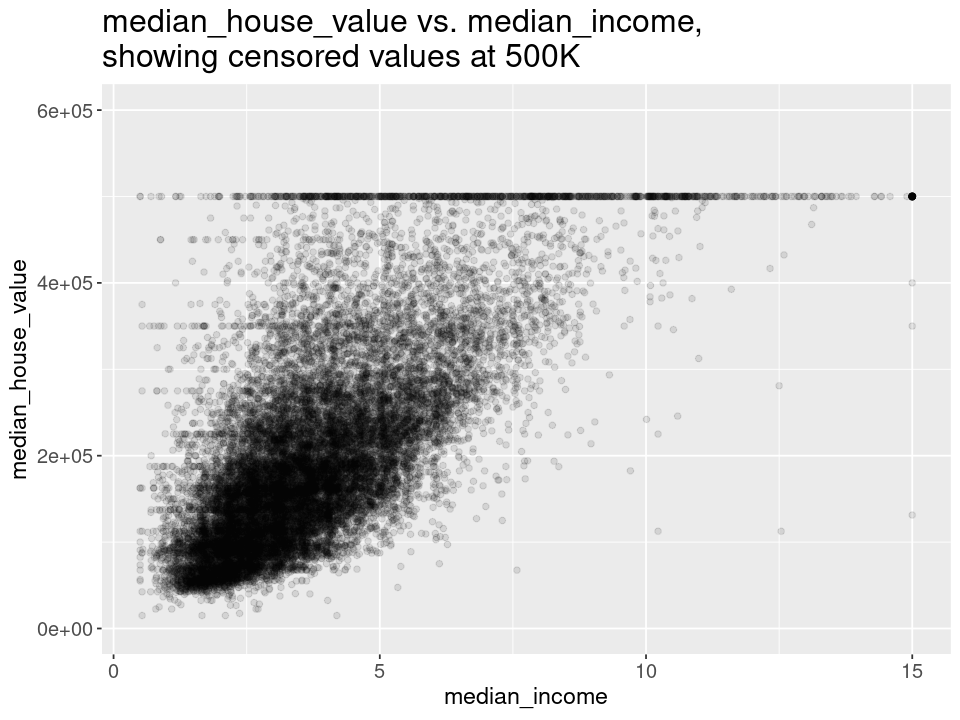

In [5]:
# Plot of median_house_value vs. median_income. 
# 4.8% of the data is censored at 500K.

options(repr.plot.width= 8, repr.plot.height= 6)

p <- ggplot(dat, aes(median_income, median_house_value)) +
  geom_point(alpha= 0.1) + xlab("median_income") + ylab("median_house_value") +
  ylim(0, 600000) +
  ggtitle("median_house_value vs. median_income, 
showing censored values at 500K") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
  
p


In [6]:
# There are 990 records, or districts, with a 
# censored median_house_value.

nrow(dat[which(dat$median_house_value >= 500000),])


[1] 990

## Get record counts for 15K interval bins of median_house_value

In order to mimic the age-level counts from Appendix A, we need to discretize median_house_value.  For presentation purposes, I have chosen 15K rather than 10K for the interval size in order to reduce the variability in the counts.

For modeling purposes I make use of 10K bins because I want a prediction at 500K and 500K is not divisible by 15K.  This lack of even division could potentially have a negative effect on the prediction at 500K.

In [7]:
summary(dat$median_house_val)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  14999  119600  179800  206908  264950  500001 

In [8]:
# Let 15K be the lowest median_house_value in our dataset.

dat[which(dat$median_house_value < 15000), c("median_house_value")] <- 15000


In [10]:
# Function for obtaining the number of records in each 15K 
# interval.

get_rcd_counts <- function(med_houseVal, varRange, 
                           span=15000, startpt=15000) {  
    
    cell_floors <- seq(from=startpt, to=990000, by=span)
    names(cell_floors) <- paste(as.character(cell_floors/1000), "K", sep="")
    
    cell_floors_tmp <- cell_floors[(as.numeric(cell_floors) >= varRange[1]) &
                                   (as.numeric(cell_floors) <= varRange[2])]
    
    # This function returns record counts up to, but not including,
    # varRange[2].
    n <- length(cell_floors_tmp) - 1
    counts <- rep(NA, n)
    for(i in 1:n) {
        lower <- as.numeric(cell_floors_tmp[i])
        upper <- as.numeric(cell_floors_tmp[i + 1])
        counts[i] <- length(med_houseVal[((med_houseVal >= lower) &
                                          (med_houseVal < upper))])
    }
    names(counts) <- names(cell_floors_tmp)[1:n]
    return(counts) 
}


In [9]:
cell_floors <- seq(from= 15000, to= 495000, by= 15000)
length(cell_floors)
names(cell_floors) <- paste(as.character(cell_floors/1000), "K", sep="")
print(cell_floors)


[1] 33

   15K    30K    45K    60K    75K    90K   105K   120K   135K   150K   165K 
 15000  30000  45000  60000  75000  90000 105000 120000 135000 150000 165000 
  180K   195K   210K   225K   240K   255K   270K   285K   300K   315K   330K 
180000 195000 210000 225000 240000 255000 270000 285000 300000 315000 330000 
  345K   360K   375K   390K   405K   420K   435K   450K   465K   480K   495K 
345000 360000 375000 390000 405000 420000 435000 450000 465000 480000 495000 


In [11]:
observed_counts <- get_rcd_counts(dat$median_house_value, c(15000, 495000))

print(observed_counts)


 15K  30K  45K  60K  75K  90K 105K 120K 135K 150K 165K 180K 195K 210K 225K 240K 
  14   78  587  965 1025 1295 1205 1088 1284 1538 1234 1239  842  931  959  747 
255K 270K 285K 300K 315K 330K 345K 360K 375K 390K 405K 420K 435K 450K 465K 480K 
 656  615  439  355  353  400  386  266  207  190  163  135  115  134   81   68 


In [12]:
# Get the number of records not captured in observed_counts.

nrow(dat) - (sum(observed_counts) + 990)


[1] 19

In [13]:
# The 19 records are between 495K and 500K.

nrow(dat[which((dat$median_house_value >= 495000) & 
               (dat$median_house_value < 500000)),])

excluded_rows <- rownames(dat[which((dat$median_house_value >= 495000) & 
                                    (dat$median_house_value < 500000)),])


[1] 19

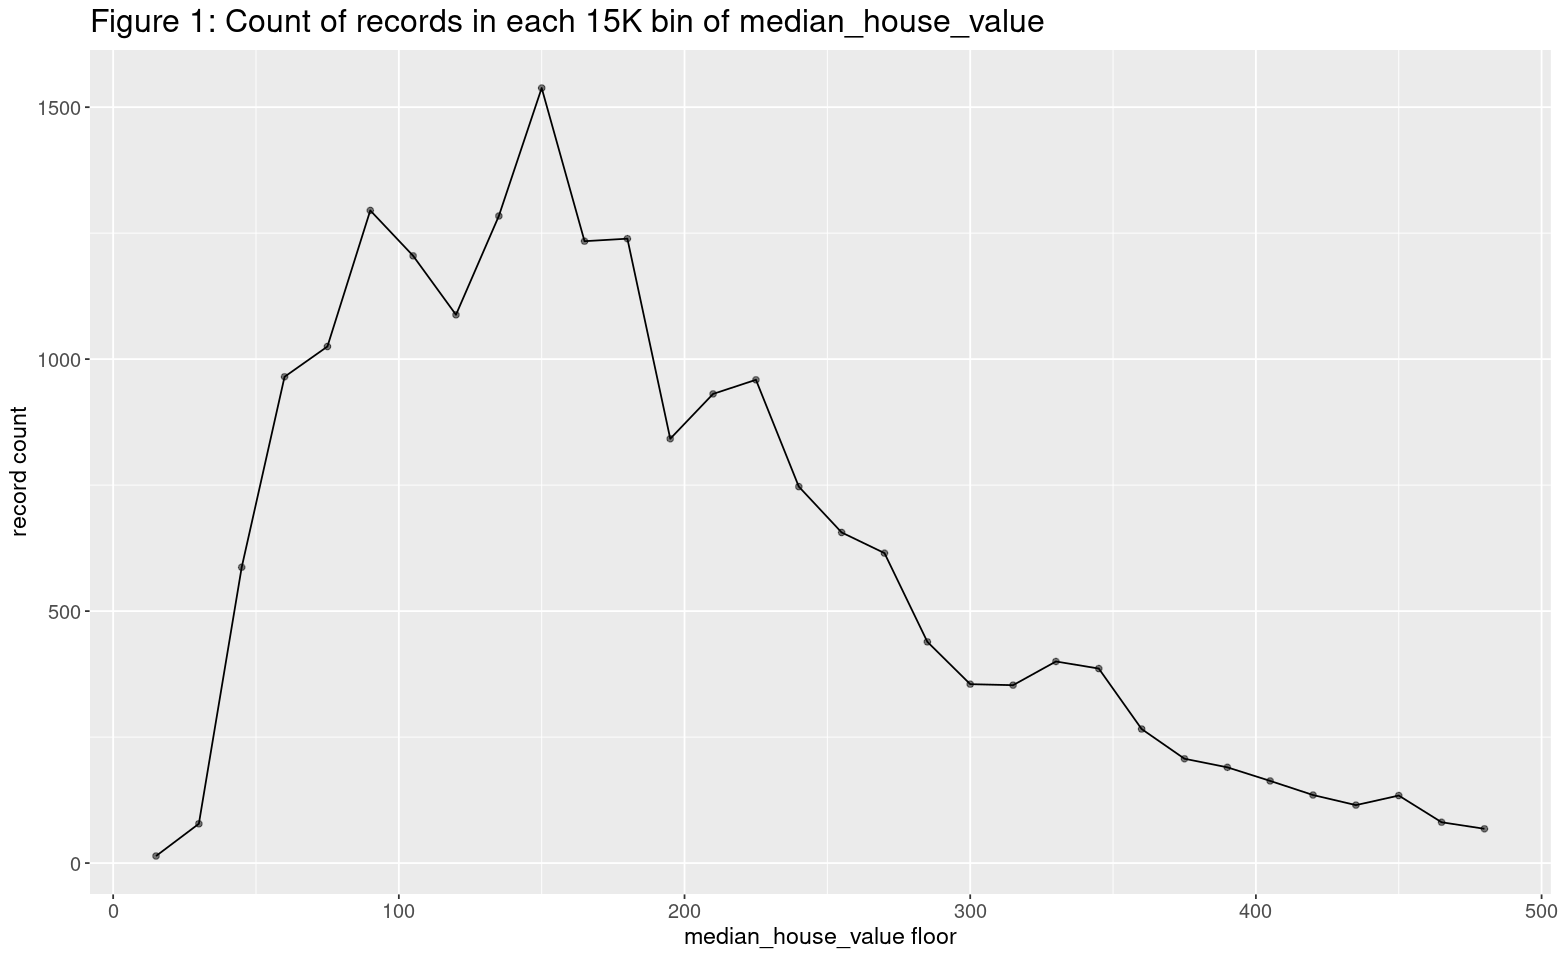

In [14]:
# Plot the counts.  This will give us a very general idea
# of what the distribution of counts might look like for the
# 990 records which need an imputed value.  We are especially
# interested in the general shape of the distribution from
# around 350K onwards.

df_plot <- rep(NA, 2 * length(observed_counts))
dim(df_plot) <- c(length(observed_counts), 2)
df_plot <- as.data.frame(df_plot)
colnames(df_plot) <- c("cell", "count")

new_names <- str_replace_all(names(observed_counts), "[K]", "")
df_plot$cell <- as.numeric(new_names)
df_plot$count <- as.numeric(observed_counts)


options(repr.plot.width= 13, repr.plot.height= 8)

p <- ggplot(df_plot, aes(cell, count)) +
  geom_point(alpha= 0.5) + xlab("median_house_value floor") + 
  ylab("record count") +
  geom_line() +
  ggtitle("Figure 1: Count of records in each 15K bin of median_house_value") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [15]:
# There is much less variability in the tail of the distribution.

dim(df_plot)
print(sd(df_plot$count))
print(sd(df_plot[24:32,]$count))


[1] 32  2

[1] 460.4
[1] 62.905


## Hypothesized distribution

We have a general idea of what the distribution of the actual, unobserved values will look like.  Here I construct an example, or hypothesized, distribution.  We know that as median house values increase, the number of districts (i.e., census blocks) will decrease; the correlation between these two variables is over 90\%.  Among the 990 records for which we need to impute a value, there are probably a few outliers, but we do not need to worry about trying to predict for these.  Instead, we are interested in approximating what is likely to be the distribution for the vast majority of records.

The hypothesized distribution provides us with a way to judge the plausibility of our model-based prediction for the mean.



In [16]:
# Create an example, or hypothesized, distribution for the 
# expected range of imputation.  (Previous work shows an 
# upper limit around 840K; so for this example distribution
# I will go out only to the 825K bin.)

bins <- seq(495000, 825000, by= 15000)
bin_names <- paste(as.character(bins/1000), "K", sep="")
names(bins) <- bin_names
names(bins)
length(bins)
# 23

# In addition to the 990 records to distribute, we have 19
# records that belong to the 495K cell.
bin_counts <- c(89, 95, 89, 86, 78, 71, 67, 65, 56, 51, 48, 
                42, 38, 35, 27, 22, 17, 12, 7,  6,  2,  3, 3)
sum(bin_counts)
sum(bin_counts) == (990 + 19)


[1] "495K" "510K" "525K" "540K" "555K" "570K" "585K" "600K" "615K" "630K"
[11] "645K" "660K" "675K" "690K" "705K" "720K" "735K" "750K" "765K" "780K"
[21] "795K" "810K" "825K"

[1] 23

[1] 1009

[1] TRUE

In [17]:
# Construct a dataframe for plotting of the example distribution.

all_names <- c(df_plot$cell[24:32], bin_names)
observed <- df_plot$count[24:32]

all <- c(observed, bin_counts)
n <- length(all)

dftmp <- rep(NA, 2 * n)
dim(dftmp) <- c(n, 2)
dftmp <- as.data.frame(dftmp)
colnames(dftmp) <- c("cell", "count")
dftmp$cell <- all_names
dftmp$count <- all

dftmp$hhval <- as.numeric(str_replace_all(dftmp$cell, "[K]", ""))

head(dftmp); tail(dftmp)


,cell,count,hhval
,<chr>,<dbl>,<dbl>
1,360,266,360
2,375,207,375
3,390,190,390
4,405,163,405
5,420,135,420
6,435,115,435


,cell,count,hhval
,<chr>,<dbl>,<dbl>
27,750K,12,750
28,765K,7,765
29,780K,6,780
30,795K,2,795
31,810K,3,810
32,825K,3,825


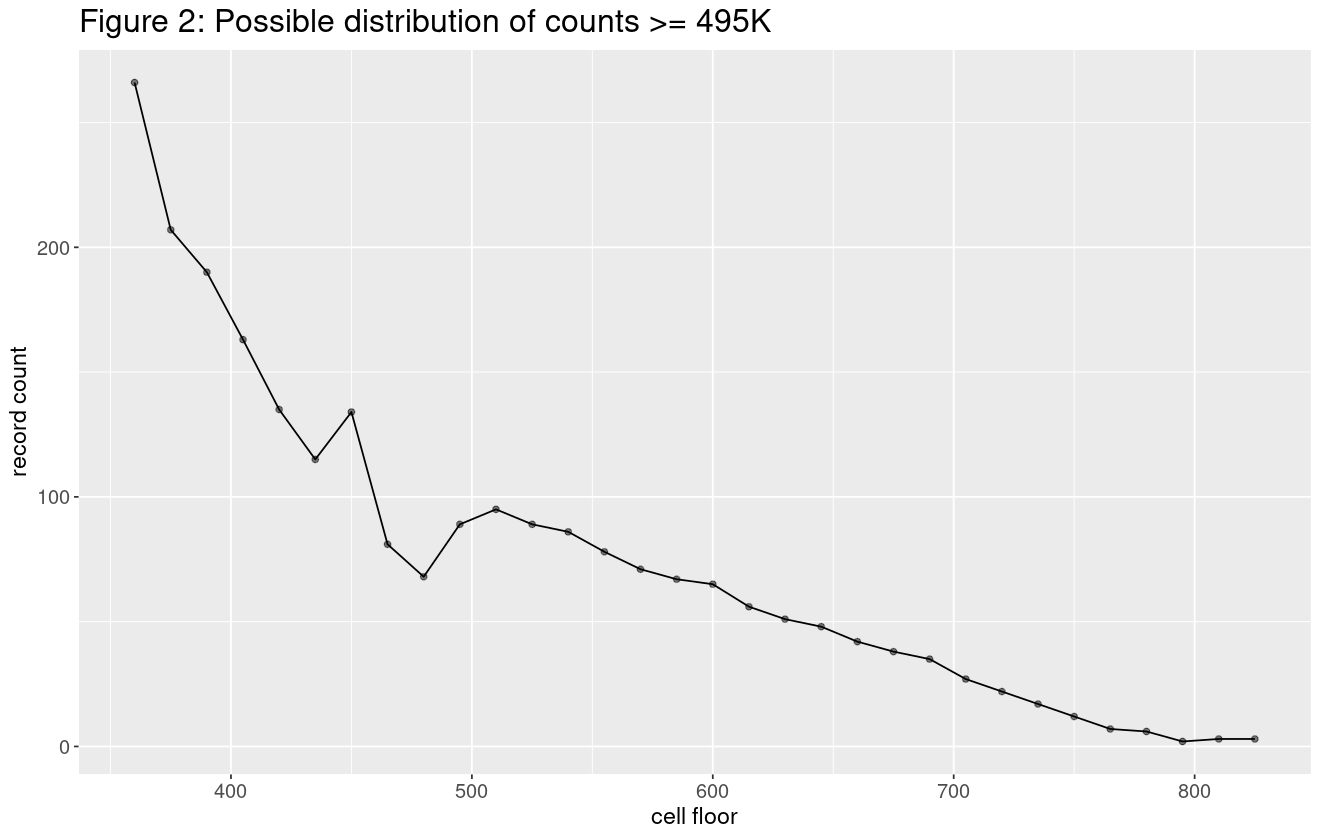

In [18]:
# Plot showing possible distribution of 990 + 19 districts 
# with a median_house_value >= 495K.

options(repr.plot.width= 11, repr.plot.height= 7)

p <- ggplot(dftmp, aes(hhval, count)) +
  geom_point(alpha= 0.5) + xlab("cell floor") + ylab("record count") +
  geom_line() +
  ggtitle("Figure 2: Possible distribution of counts >= 495K") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [19]:
# Compute the mean and median of our example distribution.
# These become our first estimates of the mean and median
# of the actual, unobserved median house values >= 500K.

dftmp <- dftmp[which(dftmp$hhval >= 495),]

# newvals will be used in cells downstream.
newvals <- c()
for(i in 1:nrow(dftmp)) {
    
    # Remove the 19 rcds >= 495K and < 500K.
    ifelse(i > 1, n <- dftmp$count[i], n <- dftmp$count[i] - 19)
    
    ifelse(i > 1, lower <- dftmp$hhval[i], lower <- dftmp$hhval[i] + 5)
    ifelse(i > 1, upper <- lower + 15, upper <- lower + 10)
    
    seed <- set.seed(4321 + i)
    vals <- round(runif(n, lower, upper))
    newvals <- c(newvals, vals)
}

length(newvals)
# 990
round(mean(newvals), 1)
# 599.7
round(median(newvals), 1)
# 586.5


[1] 990

[1] 599.7

[1] 586.5

In [ ]:
### COMMENTS:

# The example distribution has a mean of 600K.  This is an 
# estimate for the mean of the actual, unobserved median 
# house values >= 500K.  The estimate for the median is 
# lower, as expected. 


## Re-bin median_house_value using 10K intervals

In [20]:
# We have 990 imputed values.

imputed_vals_tmp <- 1000*newvals


In [21]:
# Combine the newly imputed values with the median house
# values in dat that are not censored.

all_hh_median_vals <- c(dat[which(dat$median_house_value < 500000), c("median_house_value")],
                        imputed_vals_tmp)
length(all_hh_median_vals)
summary(all_hh_median_vals)


[1] 20603

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  15000  119600  179800  211700  264950  836000 

In [22]:
# Get record counts in each 10K bin from 50K up to 840K.

all_counts <- get_rcd_counts(all_hh_median_vals, c(50000, 840000), span=10000, startpt=50000)

print(all_counts)


 50K  60K  70K  80K  90K 100K 110K 120K 130K 140K 150K 160K 170K 180K 190K 200K 
 481  625  598  767  919  734  847  723  847  802  968  999  805  852  694  535 
210K 220K 230K 240K 250K 260K 270K 280K 290K 300K 310K 320K 330K 340K 350K 360K 
 637  676  577  494  448  461  454  336  264  232  234  242  264  242  280  200 
370K 380K 390K 400K 410K 420K 430K 440K 450K 460K 470K 480K 490K 500K 510K 520K 
 145  128  127  113  113   82   99   69  109   50   56   47   40   66   64   63 
530K 540K 550K 560K 570K 580K 590K 600K 610K 620K 630K 640K 650K 660K 670K 680K 
  58   54   65   45   47   46   46   47   41   33   33   38   29   31   22   27 
690K 700K 710K 720K 730K 740K 750K 760K 770K 780K 790K 800K 810K 820K 830K 
  25   18   18   16   11   14    9    5    5    3    3    2    2    3    1 


In [23]:
length(all_counts)
which(names(all_counts)== "500K")


[1] 79

[1] 46

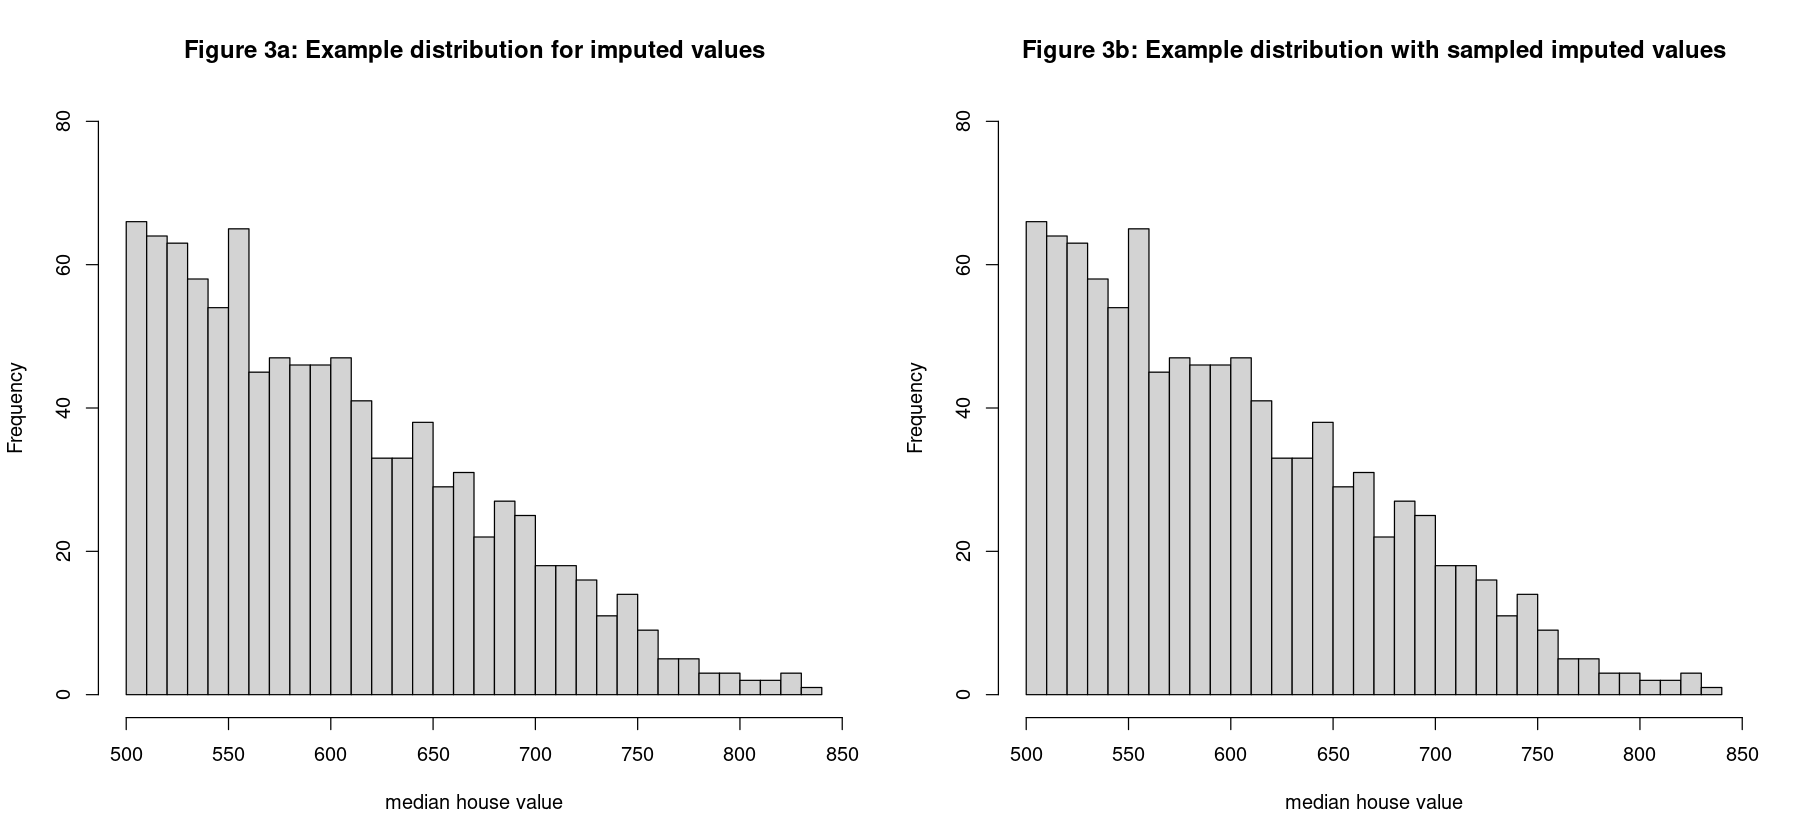

In [24]:
# The histogram below shows the counts for the example
# distribution; this is a close-up of Figure 2.

## NOTE: In order for the following histograms to look right,
## I need to add 1 to my values.

tbl <- all_counts[46:79]

options(repr.plot.width= 15, repr.plot.height= 7)

mat <- t(as.matrix(c(1,2)))
layout(mat, widths = rep.int(20, ncol(mat)),
       heights = rep.int(7, nrow(mat)), respect = FALSE)

hist(rep(seq(500, 830, by=10), as.numeric(tbl)) + 1, breaks=30, xlab="median house value",
     main="Figure 3a: Example distribution for imputed values", ylim=c(0, 80))

hist(newvals + 1, breaks= 30, xlab="median house value", ylim=c(0, 80),
     main="Figure 3b: Example distribution with sampled imputed values")


In [ ]:
### COMMENTS:

# Following Appendix A, I rely on Figures 2, 3b, and 4 for 
# judging the plausibility of predicted means and medians
# using the models that follow.


In [25]:
# Smooth out the counts in our 10K bins.

print(tbl[1:30])


500K 510K 520K 530K 540K 550K 560K 570K 580K 590K 600K 610K 620K 630K 640K 650K 
  66   64   63   58   54   65   45   47   46   46   47   41   33   33   38   29 
660K 670K 680K 690K 700K 710K 720K 730K 740K 750K 760K 770K 780K 790K 
  31   22   27   25   18   18   16   11   14    9    5    5    3    3 


In [26]:
tbl["500K"] <- 67; tbl["510K"] <- 65
tbl["530K"] <- 60; tbl["540K"] <- 57
tbl["550K"] <- 55; tbl["560K"] <- 51

tbl["570K"] <- 48; tbl["590K"] <- 43
tbl["600K"] <- 42; tbl["620K"] <- 38
tbl["630K"] <- 35; tbl["640K"] <- 32
tbl["670K"] <- 25

sum(tbl)


[1] 990

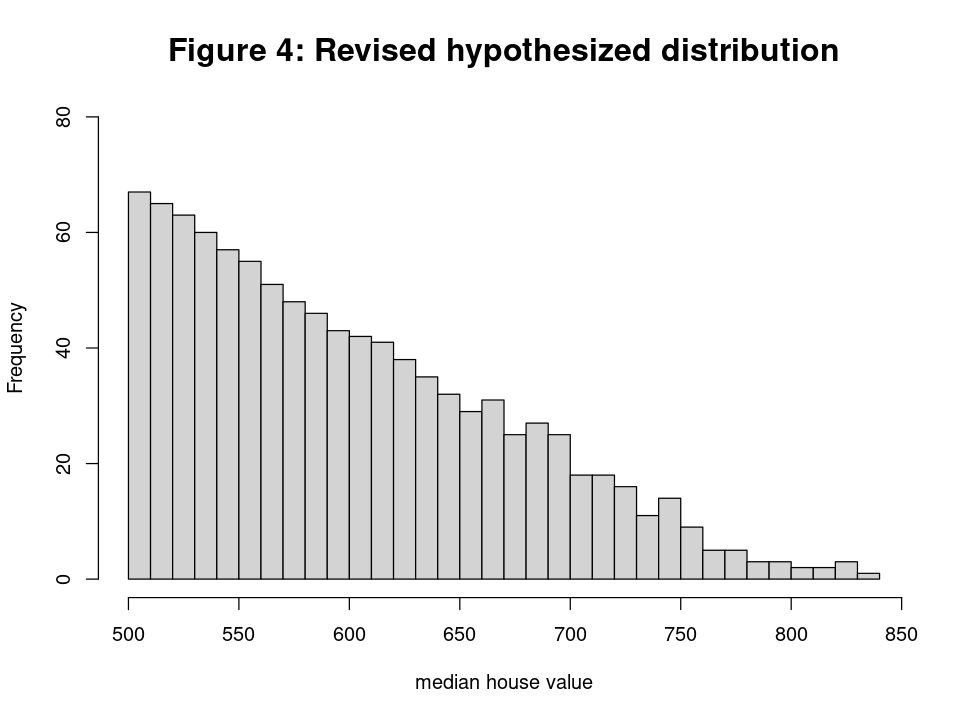

In [32]:
# Check the shape of the revised hypothesized distribution.

options(repr.plot.width= 8, repr.plot.height= 6)

hist(rep(seq(500, 830, by=10), as.numeric(tbl)) + 1, breaks=30, xlab="median house value",
     main="Figure 4: Revised hypothesized distribution", 
     cex.main= 1.6, ylim=c(0, 80))


In [28]:
# Re-compute the mean and median of our hypothesized distribution.

# newvals will be used in cells downstream.
newvals <- c()
for(i in 1:length(tbl)) {
    
    n <- as.numeric(tbl[i])
    bin_name <- names(tbl[i])
    bin_name <- str_replace(bin_name, "K", "")
    lower <- as.numeric(bin_name)
    upper <- lower + 10
    
    seed <- set.seed(4321 + i)
    vals <- round(runif(n, lower, upper))
    newvals <- c(newvals, vals)
}

length(newvals)
# 990
round(mean(newvals), 1)
# 600.1
round(median(newvals), 1)
# 586


[1] 990

[1] 600.1

[1] 586

In [208]:
imputed_vals_tmp <- 1000 * newvals


In [ ]:
### COMMENTS:

# PREDICTION FOR THE MEAN: 600K

# PREDICTION FOR THE MEDIAN: 586K


## Compute shift-increment ratios for the mean with 300K window

I will start by using a rolling window of 300K.  This window captures nearly all of the current example distribution of the imputed  values when we start at the cap of 500K (500K + 300K = 800K).  Compute data for our prediction model from 50K - 330K.  Although this takes us into the region of imputed values (we will use the example distribution of Figure 4), most of the data for the last few 300K windows will still be observed rather than imputed.  See Appendix A for an example; by doing this, I should be able to obtain a far more accurate prediction for the mean.  The hypothesized distribution shows us what we think will happen between 500K and 840K; revisit Figure 2 to judge the plausibility in the larger context.  Another plausible distribution is one in which the counts drop more quickly and in which the tail extends much further to the right, and/or we have a few distant outliers.  While distant outliers can change the mean quite a bit, I am interested in only in trying to get good predictions for the vast majority of the median house values >= 500K.  Thus our focus should be on where the mean might lie for this majority of values, nearly all of which will lie below 800K.  (Keep in mind that the median is for a census block; on average these blocks have around 400 households.  This makes it difficult for the median values to get too high.)

In Appendix A we saw that predicting the median is not so easy.  Here I am not going to worry about getting a prediction for the median.  As in Appendix A, we know that the median will lie somewhere to the left of the mean, and our hypothesized distribution gives us some idea of the expected distance between the mean and the median.

We will see below that the 300K window is too large; we are looking out further than we ought to for bins < 500K.  This inflates the ratios we rely on for our prediction; we thus end up with a prediction that is much higher than the 600K prediction we have from the hypothesized distribution.  The solution is to reduce the size of the window, perhaps down to 180K.



In [33]:
bins <- seq(50000, 330000, by= 10000)
bin_names <- paste(as.character(bins/1000), "K", sep="")
names(bins) <- bin_names
length(bins)


[1] 29

In [209]:
# See Figure 3b.
summary(newvals)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    500     539     586     600     650     838 

In [210]:
# Combine the newly imputed values with the median house
# values in dat that are not censored.

all_hh_median_vals <- c(dat[which(dat$median_house_value < 500000), c("median_house_value")],
                        newvals*1000)
length(all_hh_median_vals)
summary(all_hh_median_vals)


[1] 20603

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  15000  119600  179800  211717  264950  838000 

In [36]:
# Get the means for each bin, using a 300K window.  Note that 300K
# is divisible by 10K, the size of each median_house_value bin.
# (This is important because it means that we are never breaking
# a bin apart when calling get_rcd_counts in the loop below.) 

mean_ratios <- rep(NA, length(bins))
means <- rep(NA, length(bins))
rcd_count <- rep(NA, length(bins))

span <- 300000
index <- 0
for(floor in bins) {
    
    index <- index + 1
    hhvals <- as.numeric(all_hh_median_vals[which((all_hh_median_vals >= floor) &
                                                  (all_hh_median_vals < (floor + span)))])
    counts <- as.numeric(get_rcd_counts(hhvals, c(floor, (floor+span)), 
                                        span=10000, startpt=50000))
    rcd_count[index] <- sum(counts)
    
    # Compute mean.
    hhval_mean <- round(mean(hhvals), 5)
    mean_ratios[index] <- round(hhval_mean/floor, 3)
    means[index] <- hhval_mean

}

paste0("These are the 300K shift increments for the means: ")
names(mean_ratios) <- bin_names
print(mean_ratios)


[1] "These are the 300K shift increments for the means: "

  50K   60K   70K   80K   90K  100K  110K  120K  130K  140K  150K  160K  170K 
3.481 3.003 2.665 2.402 2.209 2.067 1.940 1.842 1.750 1.682 1.619 1.580 1.545 
 180K  190K  200K  210K  220K  230K  240K  250K  260K  270K  280K  290K  300K 
1.509 1.482 1.452 1.422 1.403 1.392 1.380 1.368 1.356 1.350 1.348 1.340 1.328 
 310K  320K  330K 
1.316 1.306 1.299 


In [37]:
# Construct dataframe for plotting, etc.

df_ratios <- rep(NA, 4*length(mean_ratios))
dim(df_ratios) <- c(length(mean_ratios), 4)
df_ratios <- as.data.frame(df_ratios)
colnames(df_ratios) <- c("cell", "rcds","mean","mean_ratio")
df_ratios$cell <- bins
df_ratios$rcds <- rcd_count
df_ratios$mean_ratio <- mean_ratios
df_ratios$mean <- means


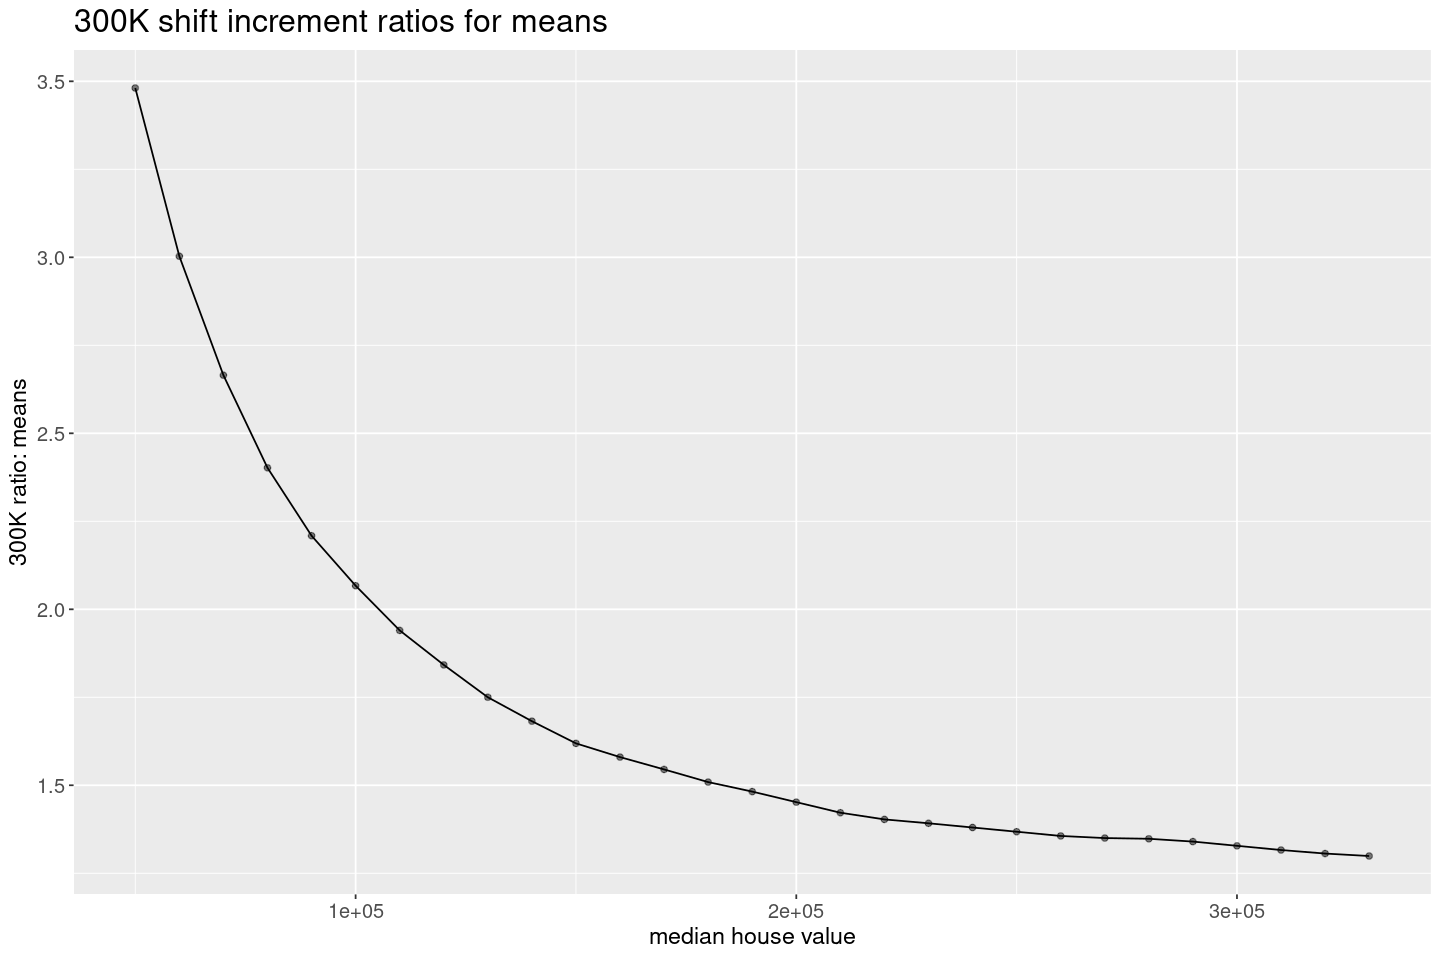

In [38]:
options(repr.plot.width= 12, repr.plot.height= 8)

p <- ggplot(df_ratios, aes(cell, mean_ratio)) +
  geom_point(alpha= 0.5) + xlab("median house value") + 
  ylab("300K ratio: means") +
  geom_line() +
  ggtitle("300K shift increment ratios for means") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [39]:
# We cannot bring rcds into our model because it is too 
# highly correlated with cell (median_house_value).  We
# might need weights on cell to establish constant variance.

df_ratios$rcds


[1] 17757 17556 17131 16678 16039 15247 14626 13892 13251 12503 11770 10911
[13]  9962  9213  8408  7754  7282  6709  6099  5581  5143  4747  4340  3935
[25]  3646  3424  3235  3044  2838

In [34]:
# Compute correlation between rcds and cell.  rcds go down
# in count as cell (median house value) increases.  If 
# these predictors are too highly correlated, I should
# remove rcds from the model.

round(cor(df_ratios$rcds^0.15, df_ratios$cell^-0.385), 3)


[1] 0.91

### Try weighted least squares

In [144]:
# Use rcds as a surrogate for cell in the weights.

g04 <- lm(I(mean_ratio^0.25) ~  I(cell^0.025) + I((cell^0.025)^2), 
          data= df_ratios, weights=df_ratios$rcds^0.025)

ans <- summary(g04)
ans[[1]] <- ""; ans



Call:
""

Weighted Residuals:
      Min        1Q    Median        3Q       Max 
-0.003143 -0.001195  0.000200  0.000906  0.002744 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)
(Intercept)         128.22       1.45    88.6   <2e-16
I(cell^0.025)      -184.65       2.15   -85.8   <2e-16
I((cell^0.025)^2)    67.04       0.80    83.8   <2e-16

Residual standard error: 0.00149 on 26 degrees of freedom
Multiple R-squared:     1,	Adjusted R-squared:     1 
F-statistic: 5.1e+04 on 2 and 26 DF,  p-value: <2e-16


In [145]:
ncvTest(g04)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 1.4571, Df = 1, p = 0.227

In [146]:
residualPlots(g04, plot=FALSE)


                  Test stat Pr(>|Test stat|)
I(cell^0.025)          3.11           0.0047
I((cell^0.025)^2)      2.60           0.0153
Tukey test             0.01           0.9924


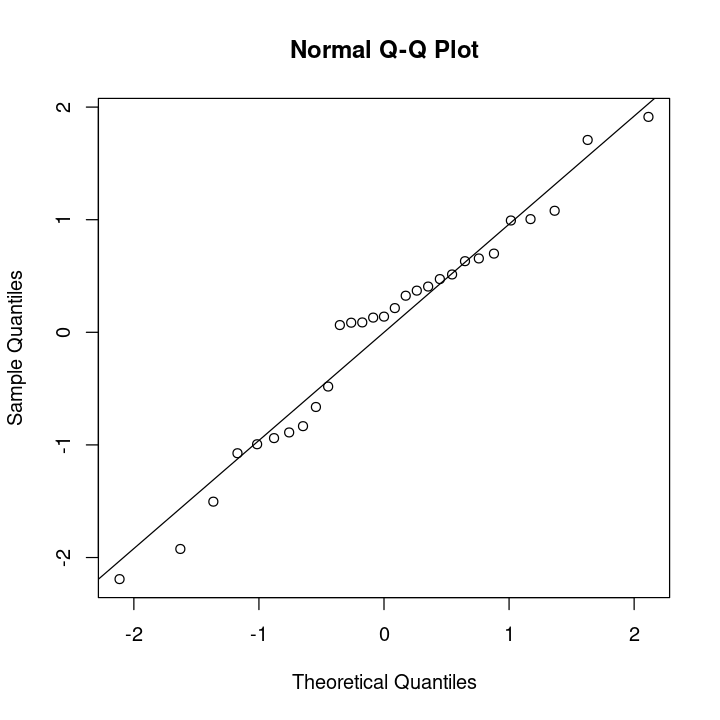

In [147]:
options(repr.plot.width= 6, repr.plot.height= 6)

ans <- qqnorm(scale(residuals(g04, type= "pearson")))
qqline(ans$x, probs = c(0.25, 0.75))


In [148]:
# Prediction for mean for [500K, 800K].

newdat <- df_ratios[1, ]
newdat[1, ] <- c(500000, 990, rep(NA, 2))

ans <- predict.lm(g04, newdata= newdat, type= "response")
ans_transf <- ans^(1/0.25); ans_transf
# 1.35

# 1.35 * 500K = 675K.


1 
1.35

In [131]:
# Compute a 95% prediction interval.

pred_ans <- predict.lm(g04, newdata= newdat, interval="prediction",
                       level=0.95, weights=990^0.025)
pred_ans_transf <- pred_ans^(1/0.25); pred_ans_transf


,fit,lwr,upr
1,1.35,1.3304,1.3697


In [132]:
lwr <- round(pred_ans_transf[2] * 500)
upr <- round(pred_ans_transf[3] * 500)

clause <- "95% prediction interval for estimate of the mean of the actual, unobserved values: "
print_ans <- paste0("[", lwr, "K, ", upr ,"K]")
paste0(clause, print_ans)
# [665K, 685K]


[1] "95% prediction interval for estimate of the mean of the actual, unobserved values: [665K, 685K]"

In [236]:
### COMMENT:

# The prediction interval does not come close to including our 
# earlier prediction of 600K.  And thus, we can conclude that 
# this model prediction is of no help to us.  The problem
# lies with the window size.  Once we reduce it, we will get
# a prediction that lies closer to 600K.


### Return to ordinary least squares

In [154]:
# The weights are not making much of a difference in g04.
# So the g05 model does not make use of them.

g05 <- lm(I(mean_ratio^0.24) ~  I(cell^0.025) + I((cell^0.025)^2), 
          data= df_ratios)

ans <- summary(g05)
ans[[1]] <- ""; ans



Call:
""

Residuals:
      Min        1Q    Median        3Q       Max 
-0.002647 -0.001071  0.000178  0.000750  0.002371 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)
(Intercept)        121.750      1.395    87.2   <2e-16
I(cell^0.025)     -175.237      2.075   -84.5   <2e-16
I((cell^0.025)^2)   63.613      0.771    82.5   <2e-16

Residual standard error: 0.00128 on 26 degrees of freedom
Multiple R-squared:     1,	Adjusted R-squared:     1 
F-statistic: 4.95e+04 on 2 and 26 DF,  p-value: <2e-16


In [155]:
ncvTest(g05)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 1.2072, Df = 1, p = 0.272

In [156]:
residualPlots(g05, plot=FALSE)


                  Test stat Pr(>|Test stat|)
I(cell^0.025)          0.59             0.56
I((cell^0.025)^2)      0.10             0.92
Tukey test            -0.48             0.63


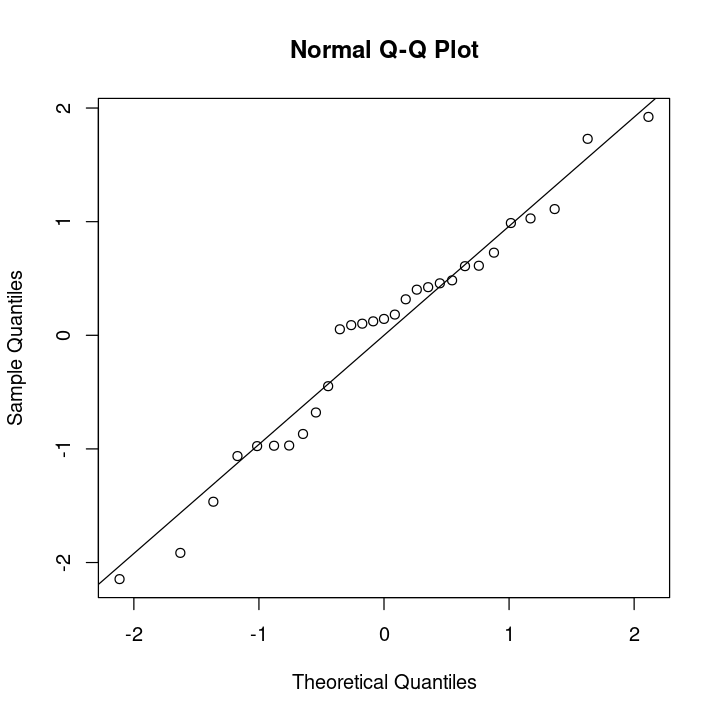

In [157]:
options(repr.plot.width= 6, repr.plot.height= 6)

ans <- qqnorm(scale(residuals(g05, type= "pearson")))
qqline(ans$x, probs = c(0.25, 0.75))


In [158]:
# Prediction for mean for [500K, 800K].

newdat <- df_ratios[1, ]
newdat[1, ] <- c(500000, 990, rep(NA, 2))

ans <- predict.lm(g05, newdata= newdat, type= "response")
ans_transf <- ans^(1/0.24); ans_transf
# 1.3477

# 1.3477 * 500K = 674K.


1 
1.3477

In [159]:
# Compute a 95% prediction interval.

pred_ans <- predict.lm(g05, newdata= newdat, interval="prediction",
                       level=0.95)
pred_ans_transf <- pred_ans^(1/0.24); pred_ans_transf


,fit,lwr,upr
1,1.3477,1.3284,1.3673


In [160]:
lwr <- round(pred_ans_transf[2] * 500)
upr <- round(pred_ans_transf[3] * 500)

clause <- "95% prediction interval for estimate of the mean of the actual, unobserved values: "
print_ans <- paste0("[", lwr, "K, ", upr ,"K]")
paste0(clause, print_ans)
# [664K, 684K]


[1] "95% prediction interval for estimate of the mean of the actual, unobserved values: [664K, 684K]"

## Compute shift-increments using a 220K window

I can size the window by looking at the last ratio in the sequence I rely on for my prediction.  If that ratio is < 1.2, then I know the window is too small.  For 1.2 * 500K = 600K, and 600K is the prediction we have from the hypothesized distribution.  So our last ratio should be > 1.2 since we are still far to the left of 500K.  When I tried a window of size 180K, the last ratio (for 370K) was 1.196 (and at 330K the ratio was even lower, at 1.186).  So here I will try 220K.

In [42]:
bins <- seq(50000, 340000, by= 10000)
bin_names <- paste(as.character(bins/1000), "K", sep="")
names(bins) <- bin_names
length(bins)


[1] 30

In [43]:
mean_ratios <- rep(NA, length(bins))
means <- rep(NA, length(bins))
rcd_count <- rep(NA, length(bins))

span <- 220000
index <- 0
for(floor in bins) {
    
    index <- index + 1
    hhvals <- as.numeric(all_hh_median_vals[which((all_hh_median_vals >= floor) &
                                                  (all_hh_median_vals < (floor + span)))])
    counts <- as.numeric(get_rcd_counts(hhvals, c(floor, (floor+span)), 
                                        span=10000, startpt=50000))
    rcd_count[index] <- sum(counts)
    
    # Compute mean.
    hhval_mean <- round(mean(hhvals), 5)
    mean_ratios[index] <- round(hhval_mean/floor, 3)
    means[index] <- hhval_mean

}

paste0("These are the 300K shift increments for the means: ")
names(mean_ratios) <- bin_names
print(mean_ratios)


[1] "These are the 300K shift increments for the means: "

  50K   60K   70K   80K   90K  100K  110K  120K  130K  140K  150K  160K  170K 
3.097 2.691 2.402 2.177 2.012 1.892 1.785 1.707 1.634 1.582 1.532 1.494 1.466 
 180K  190K  200K  210K  220K  230K  240K  250K  260K  270K  280K  290K  300K 
1.436 1.413 1.390 1.360 1.342 1.328 1.319 1.303 1.289 1.278 1.272 1.264 1.253 
 310K  320K  330K  340K 
1.243 1.234 1.228 1.226 


In [44]:
# Construct dataframe for plotting, etc.

df_ratios <- rep(NA, 4*length(mean_ratios))
dim(df_ratios) <- c(length(mean_ratios), 4)
df_ratios <- as.data.frame(df_ratios)
colnames(df_ratios) <- c("cell", "rcds","mean","mean_ratio")
df_ratios$cell <- bins
df_ratios$rcds <- rcd_count
df_ratios$mean_ratio <- mean_ratios
df_ratios$mean <- means


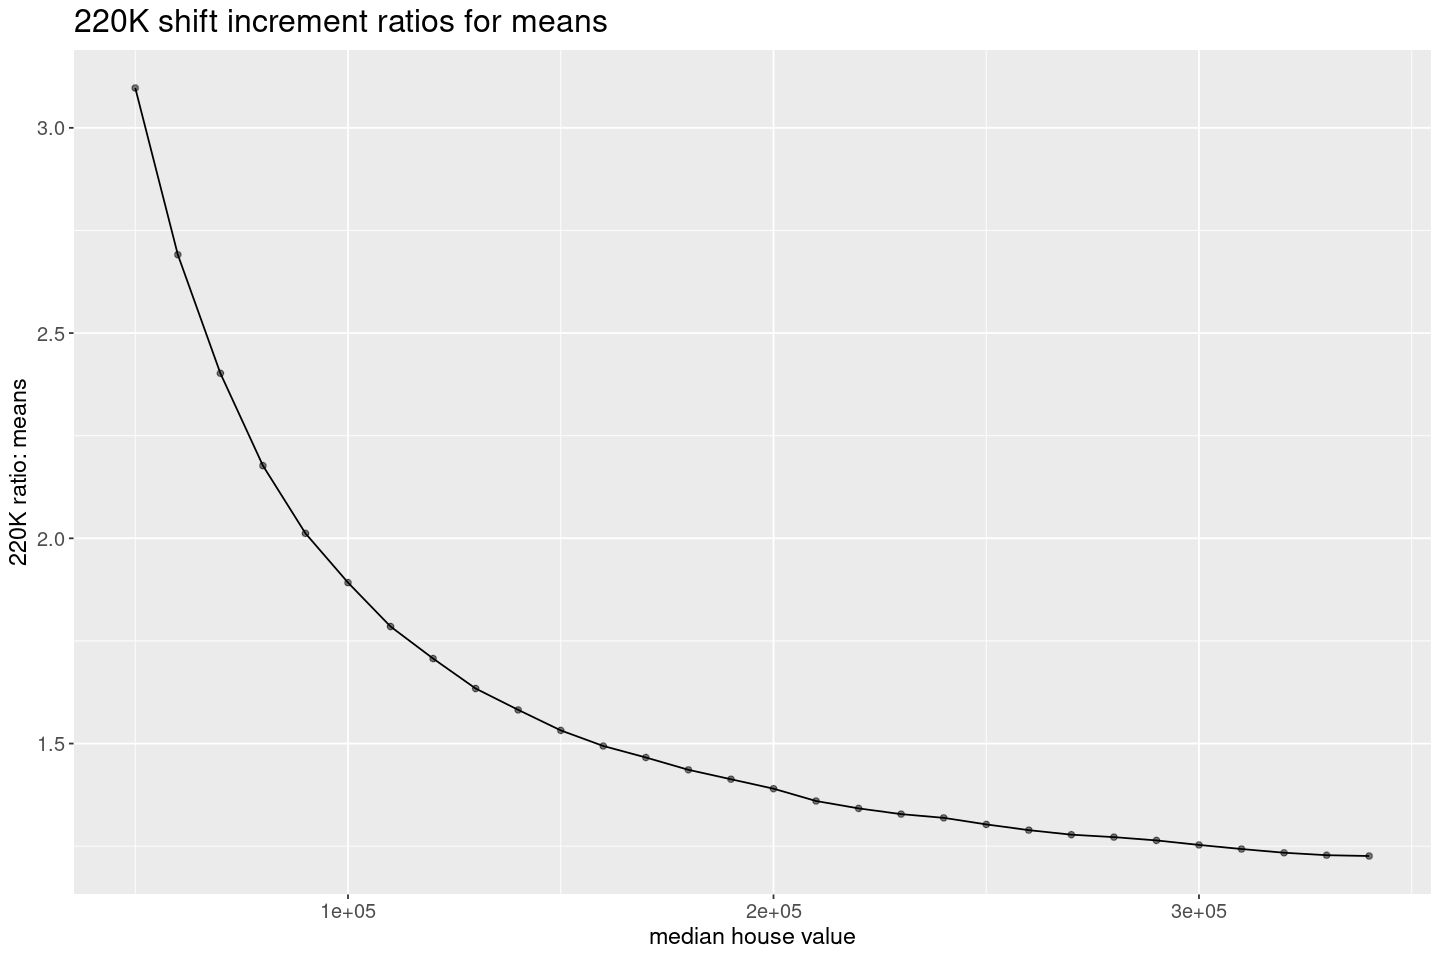

In [45]:
options(repr.plot.width= 12, repr.plot.height= 8)

p <- ggplot(df_ratios, aes(cell, mean_ratio)) +
  geom_point(alpha= 0.5) + xlab("median house value") + 
  ylab("220K ratio: means") +
  geom_line() +
  ggtitle("220K shift increment ratios for means") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [96]:
g06 <- lm(I(mean_ratio^0.9) ~  I(cell^0.02) 
          + I((cell^0.02)^2) + I((cell^0.02)^3), 
          data= df_ratios)

ans <- summary(g06)
ans[[1]] <- ""; ans



Call:
""

Residuals:
      Min        1Q    Median        3Q       Max 
-0.004271 -0.002659 -0.000675  0.002194  0.005800 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)
(Intercept)         21499        516    41.7   <2e-16
I(cell^0.02)       -49966       1222   -40.9   <2e-16
I((cell^0.02)^2)    38718        964    40.1   <2e-16
I((cell^0.02)^3)   -10002        254   -39.4   <2e-16

Residual standard error: 0.00322 on 26 degrees of freedom
Multiple R-squared:     1,	Adjusted R-squared:     1 
F-statistic: 1.44e+05 on 3 and 26 DF,  p-value: <2e-16


In [97]:
ncvTest(g06)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.0024245, Df = 1, p = 0.961

In [98]:
residualPlots(g06, plot=FALSE)


                 Test stat Pr(>|Test stat|)
I(cell^0.02)         -0.26             0.80
I((cell^0.02)^2)      0.45             0.66
I((cell^0.02)^3)      0.46             0.65
Tukey test            0.08             0.93


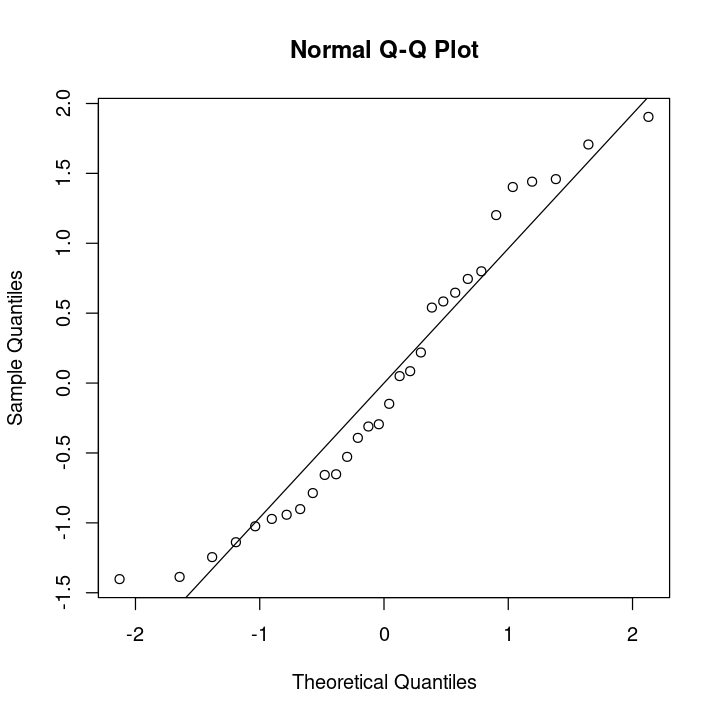

In [99]:
options(repr.plot.width= 6, repr.plot.height= 6)

ans <- qqnorm(scale(residuals(g06, type= "pearson")))
qqline(ans$x, probs = c(0.25, 0.75))


In [100]:
# Prediction for mean for [500K, 800K].

newdat <- df_ratios[1, ]
newdat[1, ] <- c(500000, 990, rep(NA, 2))

ans <- predict.lm(g06, newdata= newdat, type= "response")
ans_transf <- ans^(1/0.9); ans_transf
# 1.1138

# 1.1138 * 500K = 557K.


1 
1.1138

In [101]:
# Compute a 95% prediction interval.

pred_ans <- predict.lm(g06, newdata= newdat, interval="prediction",
                       level=0.95)
pred_ans_transf <- pred_ans^(1/0.9); pred_ans_transf


,fit,lwr,upr
1,1.1138,1.0966,1.131


In [102]:
lwr <- round(pred_ans_transf[2] * 500)
upr <- round(pred_ans_transf[3] * 500)

clause <- "95% prediction interval for estimate of the mean of the actual, unobserved values: "
print_ans <- paste0("[", lwr, "K, ", upr ,"K]")
paste0(clause, print_ans)
# [548K, 566K]


[1] "95% prediction interval for estimate of the mean of the actual, unobserved values: [548K, 566K]"

In [ ]:
### COMMENT:

# The 95% prediction interval should cover the 600K prediction.
# Since it does not when our window is at 220K, we should 
# increase the window size.  Increasing the size of our rolling
# window increases the shift-increment ratios (a surrogate for
# the mean).


## Compute shift-increments using a 240K window

If we use a 250K window, our 500K point estimate is 626K.  This is too high, since the 95% prediction interval will not cover the 600K prediction we already have.  So here I am trying a window that spans 240K.

In [160]:
# By stopping at 330K, the last ratio relies on data
# out to 570K.  As usual, we rely somewhat on the
# hypothesized distribution.

bins <- seq(50000, 330000, by= 10000)
bin_names <- paste(as.character(bins/1000), "K", sep="")
names(bins) <- bin_names
length(bins)


[1] 29

In [161]:
mean_ratios <- rep(NA, length(bins))
means <- rep(NA, length(bins))
rcd_count <- rep(NA, length(bins))

span <- 240000
index <- 0
for(floor in bins) {
    
    index <- index + 1
    hhvals <- as.numeric(all_hh_median_vals[which((all_hh_median_vals >= floor) &
                                                  (all_hh_median_vals < (floor + span)))])
    counts <- as.numeric(get_rcd_counts(hhvals, c(floor, (floor+span)), 
                                        span=10000, startpt=50000))
    rcd_count[index] <- sum(counts)
    
    # Compute mean.
    hhval_mean <- round(mean(hhvals), 5)
    mean_ratios[index] <- round(hhval_mean/floor, 3)
    means[index] <- hhval_mean

}

paste0("These are the 300K shift increments for the means: ")
names(mean_ratios) <- bin_names
print(mean_ratios)


[1] "These are the 300K shift increments for the means: "

  50K   60K   70K   80K   90K  100K  110K  120K  130K  140K  150K  160K  170K 
3.217 2.770 2.461 2.229 2.061 1.942 1.833 1.755 1.677 1.613 1.556 1.517 1.488 
 180K  190K  200K  210K  220K  230K  240K  250K  260K  270K  280K  290K  300K 
1.457 1.433 1.409 1.377 1.361 1.346 1.332 1.316 1.300 1.293 1.291 1.284 1.274 
 310K  320K  330K 
1.262 1.253 1.247 


In [162]:
# Construct dataframe for plotting, etc.

df_ratios <- rep(NA, 4*length(mean_ratios))
dim(df_ratios) <- c(length(mean_ratios), 4)
df_ratios <- as.data.frame(df_ratios)
colnames(df_ratios) <- c("cell", "rcds","mean","mean_ratio")
df_ratios$cell <- bins
df_ratios$rcds <- rcd_count
df_ratios$mean_ratio <- mean_ratios
df_ratios$mean <- means


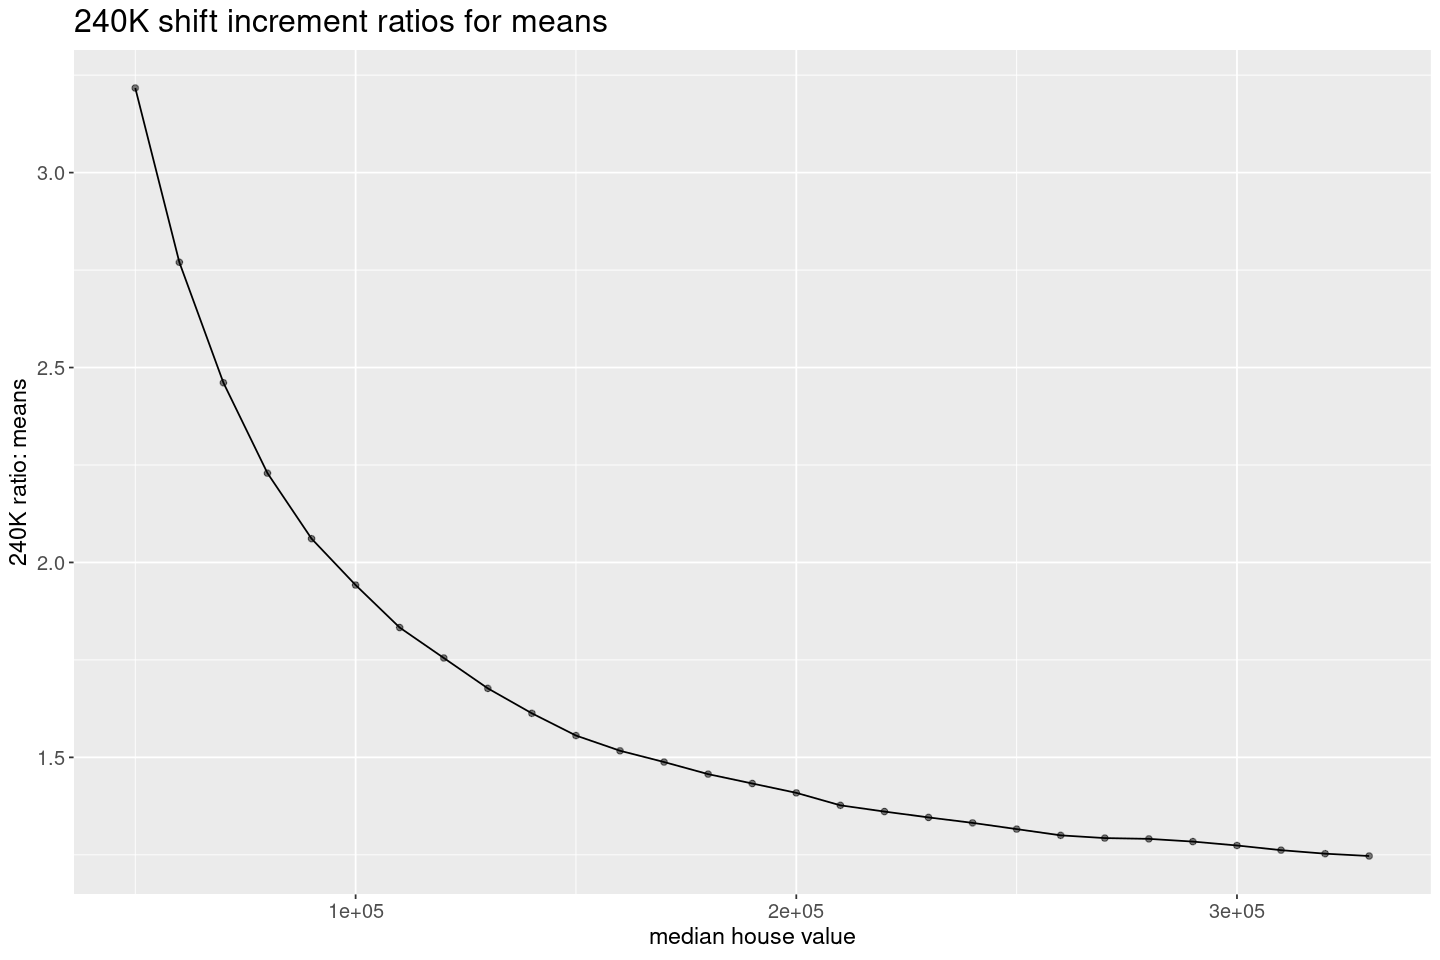

In [163]:
options(repr.plot.width= 12, repr.plot.height= 8)

p <- ggplot(df_ratios, aes(cell, mean_ratio)) +
  geom_point(alpha= 0.5) + xlab("median house value") + 
  ylab("240K ratio: means") +
  geom_line() +
  ggtitle("240K shift increment ratios for means") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [178]:
g07 <- lm(I(mean_ratio^0.27) ~  I(cell^0.04) 
          + I((cell^0.04)^2) + I((cell^0.04)^3), 
          data= df_ratios)

ans <- summary(g07)
ans[[1]] <- ""; ans



Call:
""

Residuals:
      Min        1Q    Median        3Q       Max 
-1.96e-03 -7.01e-04  2.03e-05  4.64e-04  1.78e-03 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)
(Intercept)        228.04      21.40   10.66  8.8e-11
I(cell^0.04)      -390.24      40.02   -9.75  5.3e-10
I((cell^0.04)^2)   223.46      24.94    8.96  2.8e-09
I((cell^0.04)^3)   -42.62       5.18   -8.23  1.4e-08

Residual standard error: 0.001 on 25 degrees of freedom
Multiple R-squared:     1,	Adjusted R-squared:     1 
F-statistic: 6.17e+04 on 3 and 25 DF,  p-value: <2e-16


In [179]:
ncvTest(g07)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.42315, Df = 1, p = 0.515

In [180]:
residualPlots(g07, plot=FALSE)


                 Test stat Pr(>|Test stat|)
I(cell^0.04)          0.07             0.95
I((cell^0.04)^2)     -0.08             0.94
I((cell^0.04)^3)     -0.09             0.93
Tukey test            0.01             1.00


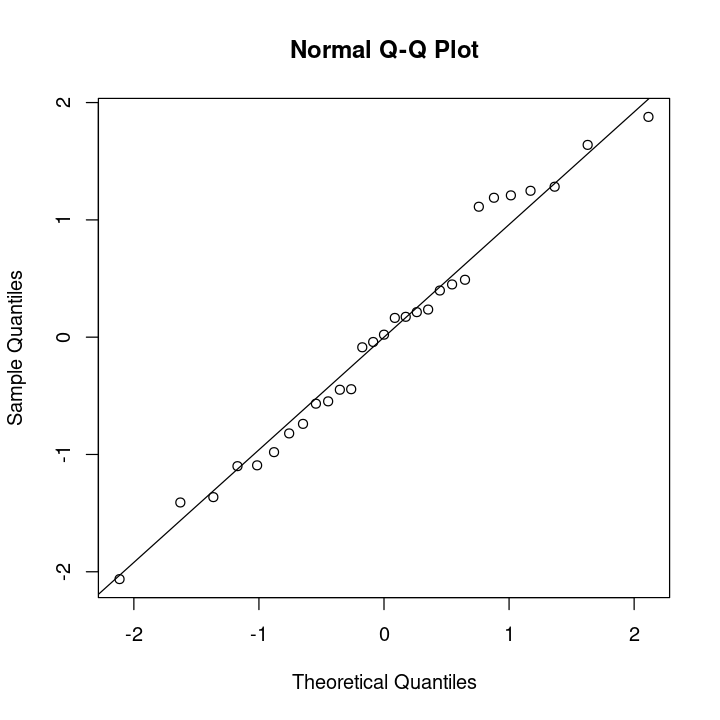

In [181]:
options(repr.plot.width= 6, repr.plot.height= 6)

ans <- qqnorm(scale(residuals(g07, type= "pearson")))
qqline(ans$x, probs = c(0.25, 0.75))


In [182]:
# Prediction for mean for [500K, 800K].

newdat <- df_ratios[1, ]
newdat[1, ] <- c(500000, 990, rep(NA, 2))

ans <- predict.lm(g07, newdata= newdat, type= "response")
ans_transf <- ans^(1/0.27); ans_transf
# 1.2093

# 1.2093 * 500K = 604.65K.


1 
1.2093

In [183]:
# Compute a 95% prediction interval.

pred_ans <- predict.lm(g07, newdata= newdat, interval="prediction",
                       level=0.95)
pred_ans_transf <- pred_ans^(1/0.27); pred_ans_transf


,fit,lwr,upr
1,1.2093,1.1864,1.2326


In [184]:
lwr <- round(pred_ans_transf[2] * 500)
upr <- round(pred_ans_transf[3] * 500)

clause <- "95% prediction interval for estimate of the mean of the actual, unobserved values: "
print_ans <- paste0("[", lwr, "K, ", upr ,"K]")
paste0(clause, print_ans)
# [593K, 616K]


[1] "95% prediction interval for estimate of the mean of the actual, unobserved values: [593K, 616K]"

## Final Comments for Section 1

As noted in Appendix A, if we have a good prediction for the mean of the actual, unobserved values (by "good" I mean a prediction which we can have a degree of confidence in), then we can improve upon the Gibbs sampler output if its predictions have a mean where we do not think it actually is.  From the above we can be fairly confident that the mean for the median house values >= 500K is close to **605K**.  We can be fairly confident that the median will be less than the mean.

As in Appendix A, it is much harder to predict for the median than it is for the mean.

We have seen in the above analysis that the size of the shift-increment window has a significant effect on the prediction we get.  We can determine an appropriate size for the window by relying on our prediction for the mean based on the hypothesized distribution.  If in the above we set the window to 220K, the 95% prediction interval is too low to include the 600K estimate.  If we set the window to 250K, the 95% prediction interval is too high to include the 600K estimate.  When we use a 240K window, however, we get a very plausible prediction---again, assuming that our hypothesized distribution provides us with what we take to be a reasonable estimate.



# Section 2: impute values for censored median house values

In [185]:
# The following model is what we will use to predict the
# median house values that we need.

m01 <- lm(I(median_house_value^0.18) ~ 
          
           I(median_income^0.77) +
           I(long_transf^-0.5) +
           I(long_transf^-1) +
           I(long_transf^-1.5) +
           latitude +
           I(latitude^2) +
           I(latitude^3) + 
           I(latitude^4) +
           pop_per_hh +
           I(pop_per_hh^2) +
           I(housing_median_age^0.15) +
           HHdens_ln +
           HHdens_ln:long_transf +
           HHdens_ln:median_income +
           HHdens_ln:housing_median_age:median_income,
                  
          data= dat)

# REMARK: dat includes the capped data; if we discard the censored
# records, we are discarding valuable information.

m01.summary <- summary(m01)
m01.summary[[1]] <- ""; round(m01.summary$adj.r.squared, 3)


[1] 0.73

In [186]:
ncvTest(m01)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.00045257, Df = 1, p = 0.983

In [187]:
residualPlots(m01, plot=FALSE)


                           Test stat Pr(>|Test stat|)
I(median_income^0.77)         -14.13           <2e-16
I(long_transf^-0.5)             1.99            0.046
I(long_transf^-1)              11.11           <2e-16
I(long_transf^-1.5)            11.55           <2e-16
latitude                        0.89            0.373
I(latitude^2)                  -0.40            0.692
I(latitude^3)                  33.30           <2e-16
I(latitude^4)                  33.28           <2e-16
pop_per_hh                     -1.32            0.186
I(pop_per_hh^2)               -13.36           <2e-16
I(housing_median_age^0.15)      0.46            0.643
HHdens_ln                      11.34           <2e-16
Tukey test                      0.07            0.945


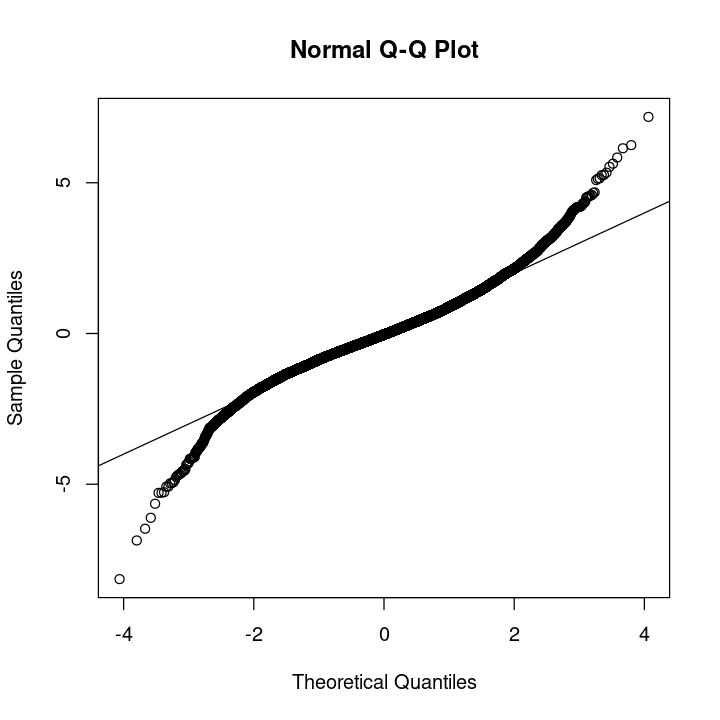

In [188]:
options(repr.plot.width= 6, repr.plot.height= 6)

ans <- qqnorm(scale(residuals(m01, type= "pearson")))
qqline(ans$x, probs = c(0.25, 0.75))


In [189]:
# Get a sense of the uncertainty for the model's sigma.
# (sim is from the arm package.)

m01.sim <- sim(m01, n.sims=3000)


In [190]:
sigma.m01.sim <- sigma.hat(m01.sim)
str(sigma.m01.sim)


 num [1:3000] 0.46 0.469 0.47 0.465 0.465 ...


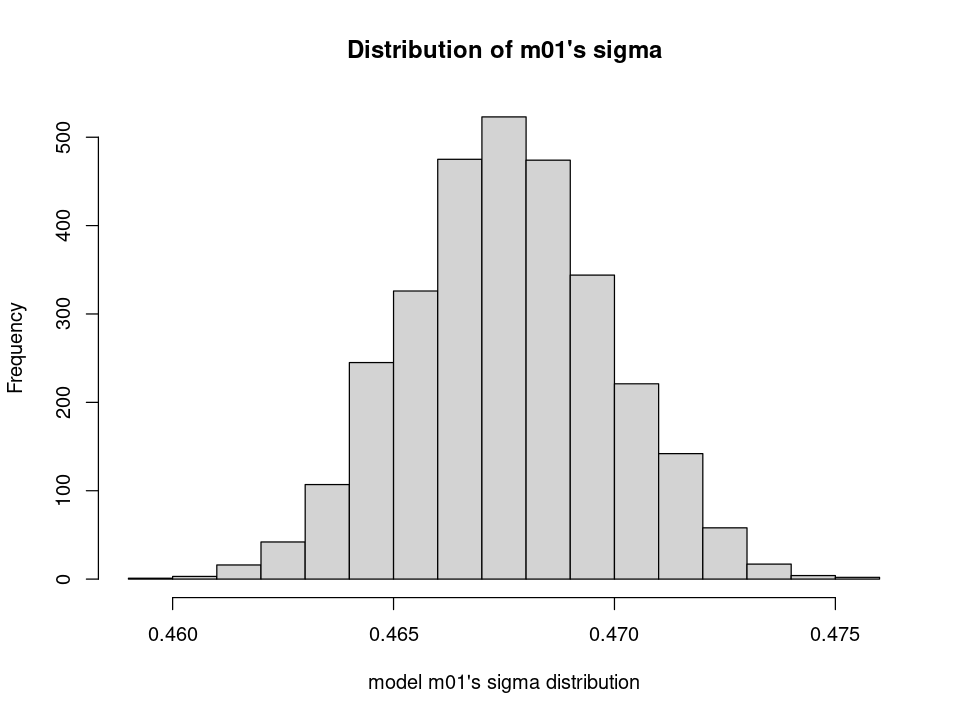

In [191]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(sigma.m01.sim, breaks=20, main="Distribution of m01's sigma",
     xlab="model m01's sigma distribution")


In [ ]:
# sigma.hat is small because of the power transformation
# on the response variable.


### Gibbs sampler for imputing censored median_house_values

In [192]:
# Because of the transformation on the response variable,
# we need to transform our limits.  Here I am setting the 
# upper limit to 800K. 

cap <- 500000
response_var_power <- 0.18
inv_pwr <- 1/response_var_power

# Set C_upper to where we think we will have accounted for
# a vast majority of the actual, unobserved values.
C <- cap^response_var_power
C_upper <- (1.6*cap)^response_var_power

censored <- (dat$median_house_value)^response_var_power >= C

# Create some crude starting values.
n.censored <- sum(censored)
z <- ifelse(censored, NA, (dat$median_house_value)^response_var_power)
z[censored] <- runif(n.censored, C, C_upper)


In [193]:
length(censored)
n.censored


[1] 20603

[1] 990

In [194]:
summary(z[censored])


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   10.6    10.8    11.1    11.1    11.3    11.5 

In [195]:
# Identify the rows that are censored.

rows_censored <- rownames(dat)[censored]
head(rows_censored)


[1] "90"  "460" "494" "495" "510" "511"

In [196]:
# Function to draw from a constrained normal distribution.

rnorm.trunc03 <- function(n, mu, sigma, lo=-Inf, hi=Inf) {
    
    # We need each mu to be >= C.  Otherwise the return 
    # value will be Inf.
    cap <- 500000
    mu02 <- ifelse(mu <= C, (cap + 100)^response_var_power, mu)
    
    p.lo <- pnorm(lo, mu02, sigma)
    p.hi <- pnorm(hi, mu02, sigma)
    u <- runif(n, p.lo, p.hi)
    return(qnorm(u, mu02, sigma))
}


In [246]:
# Create matrix X for the terms in our model.

X <- dat

X$median_income <- (X$median_income)^0.77

X$lat2 <- (X$latitude)^2
X$lat3 <- (X$latitude)^3
X$lat4 <- (X$latitude)^4

X$long_1 <- (X$long_transf)^-0.5
X$long_2 <- (X$long_transf)^-1
X$long_3 <- (X$long_transf)^-1.5

X$pphh1 <-  X$pop_per_hh
X$pphh2 <- (X$pop_per_hh)^2

X$housing_median_age <- (X$housing_median_age)^0.15

X$HHdens_by_long <- X$HHdens_ln * X$long_transf
X$HHdens_by_income <- X$HHdens_ln * X$median_income
X$HHdens_3way <- X$HHdens_ln * X$median_income * X$housing_median_age



X <- X[, c("median_income","long_1","long_2","long_3","latitude","lat2",
           "lat3","lat4","pphh1","pphh2", "housing_median_age",
           "HHdens_ln", "HHdens_by_long","HHdens_by_income",
           "HHdens_3way")]
intercept <- rep(1, nrow(dat))

init.colnames <- colnames(X)

X <- as.data.frame(cbind(intercept, X), col.names=c("intercept", init.colnames),
                   row.names=rownames(dat))
dim(X)
colnames(X)


[1] 20603    16

[1] "intercept"          "median_income"      "long_1"            
 [4] "long_2"             "long_3"             "latitude"          
 [7] "lat2"               "lat3"               "lat4"              
[10] "pphh1"              "pphh2"              "housing_median_age"
[13] "HHdens_ln"          "HHdens_by_long"     "HHdens_by_income"  
[16] "HHdens_3way"

In [247]:
# See p.406 (Section 18.5) of Gelman and Hill's book,
# "Data Analysis Using Regression and Multilevel/Hierarchical
# Models".

# Fit a regression using the crude starting values of z.

m01_tst <- lm(z ~ 
              
           I(median_income^0.77) +
           I(long_transf^-0.5) +
           I(long_transf^-1) +
           I(long_transf^-1.5) +
           latitude +
           I(latitude^2) +
           I(latitude^3) + 
           I(latitude^4) +
           pop_per_hh +
           I(pop_per_hh^2) +
           I(housing_median_age^0.15) +
           HHdens_ln +
           HHdens_ln:long_transf +
           HHdens_ln:median_income +
           HHdens_ln:housing_median_age:median_income,
                  
           data= dat)    

# Obtain a sample draw of the model coefficients and of
# parameter sigma.
sim.1 <- sim(m01_tst, n.sims=1)


In [248]:
beta <- coef(sim.1)
dim(beta)
colnames(beta)


[1]  1 16

[1] "(Intercept)"                               
 [2] "I(median_income^0.77)"                     
 [3] "I(long_transf^-0.5)"                       
 [4] "I(long_transf^-1)"                         
 [5] "I(long_transf^-1.5)"                       
 [6] "latitude"                                  
 [7] "I(latitude^2)"                             
 [8] "I(latitude^3)"                             
 [9] "I(latitude^4)"                             
[10] "pop_per_hh"                                
[11] "I(pop_per_hh^2)"                           
[12] "I(housing_median_age^0.15)"                
[13] "HHdens_ln"                                 
[14] "HHdens_ln:long_transf"                     
[15] "HHdens_ln:median_income"                   
[16] "HHdens_ln:median_income:housing_median_age"

In [249]:
# Here are means for 6 different normal
# distributions.

means <- as.matrix(X) %*% t(beta)
length(means)
round(head(as.vector(means)^inv_pwr))


[1] 20603

[1] 466164 520490 366964 297426 230703 241224

In [250]:
# All values should be between 500K and 800K
z.old <- z[censored]
round(head(z.old)^inv_pwr)


[1] 507102 504066 558000 592871 799517 620749

In [251]:
# All values should be between 500K and 800K.
sigma <- sigma.hat(sim.1)
round(sigma, 4)

z.new <- rnorm.trunc03(n.censored, means[censored], sigma, lo=C, hi=C_upper)
round(head(as.vector(z.new)^inv_pwr))


[1] 0.4976

[1] 574649 709798 616496 649026 622094 656843

In [252]:
summary(z.new^inv_pwr)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 500040  558565  621678  628473  695964  799530 

In [253]:
# For the Gibbs sampler, the above is now put into
# a loop.  We first test with 100 iterations.

n <- nrow(dat)
n.chains <- 4
n.iter <- 2000

sims <- array(NA, c(n.iter, n.chains, 17 + n.censored))
dimnames(sims) <- list(NULL, NULL, c(colnames(X), "sigma", 
                                     paste("z[", (1:n)[censored],
                                           "]", sep="")))

start <- Sys.time()
for(m in 1:n.chains) {
    
    # acquire some initial values
    z[censored] <- runif(n.censored, C, C_upper)
    
    for(t in 1:n.iter) {
        
        m01.1 <- lm(z ~ 
                    
           I(median_income^0.77) +
           I(long_transf^-0.5) +
           I(long_transf^-1) +
           I(long_transf^-1.5) +
           latitude +
           I(latitude^2) +
           I(latitude^3) + 
           I(latitude^4) +
           pop_per_hh +
           I(pop_per_hh^2) +
           I(housing_median_age^0.15) +
           HHdens_ln +
           HHdens_ln:long_transf +
           HHdens_ln:median_income +
           HHdens_ln:housing_median_age:median_income,
                  
           data= dat)   
        
        sim.1 <- sim(m01.1, n.sims=1)
        beta <- coef(sim.1)
        sigma <- sigma.hat(sim.1)
        means <- as.matrix(X) %*% t(beta)
        z[censored] <- rnorm.trunc03(n.censored, means[censored], sigma, lo=C, hi=C_upper)
        stopifnot(sum(z[censored] < Inf) == n.censored)
        sims[t,m,] <- c(beta, sigma, z[censored])
    }
}

stop <- Sys.time()
round(stop - start, 2)
# Time difference of 3.88 minutes.


Time difference of 3.88 mins

In [242]:
# Check for convergence.

# sims.bugs <- R2OpenBUGS::as.bugs.array(sims, n.burnin=1000)
# print(sims.bugs)

# The Rhat value for every parameter and every imputed
# value should be 1.0.


In [254]:
save(sims, file="/home/greg/Documents/stat/Geron_ML/datasets/housing/sims_raw_hhvals.RData")


In [197]:
load("/home/greg/Documents/stat/Geron_ML/datasets/housing/sims_raw_hhvals.RData")


In [198]:
# Drop the first 1000 iterations.

sims_adj <- sims[1001:2000, ,]
dim(sims_adj)


[1] 1000    4 1007

In [199]:
sims_adj.bugs <- R2OpenBUGS::as.bugs.array(sims_adj)
# print(sims_adj.bugs)


In [200]:
# Extract the means and stddevs for each of the censored records.

z_means <- sims_adj.bugs$mean$z
z_sds <- sims_adj.bugs$sd$z
round(head(z_means), 2); round(head(z_sds), 2)


[1] 10.96 10.95 10.96 10.96 10.96 11.17

[1] 0.23 0.24 0.24 0.24 0.24 0.24

In [201]:
summary(z_means)
summary(z_sds)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   10.9    11.0    11.0    11.0    11.1    11.4 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.103   0.236   0.239   0.237   0.245   0.257 

In [202]:
summary(round(z_means^inv_pwr))


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 594362  597354  598802  620628  633302  758891 

In [203]:
# Average estimate of the sd.

(sd_estimate <- round((11 + 0.237)^inv_pwr) - round(11^inv_pwr))
# 76,724


[1] 76724

In [204]:
# Here is a fuller summary for the stddevs.

ans <- round((z_means + z_sds)^inv_pwr) - round(z_means^inv_pwr)
summary(ans)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  38816   75314   76235   77571   81054   87973 

In [ ]:
### COMMENTS:

# Based on the work above, we expect the mean to be 600K -
# 605K if the upper limit is around 770K.  The mean is
# currently around 629K (see next summary).


In [205]:
# Get some predictions, using rnorm.trunc03.

set.seed(1931)
z_preds <- round(rnorm.trunc03(n.censored, z_means, z_sds, lo=C, hi=C_upper), 5)
z_preds <- round(z_preds^inv_pwr)
summary(z_preds)

# Notice that the mean is at 629K.  We do not expect the mean 
# to be this high.  In fact, this mean is not even in the 
# 95% prediction interval from the g07 model prediction.  The
# upper limit for that prediction interval is 616K.


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 500782  573851  624113  629122  677362  799914 

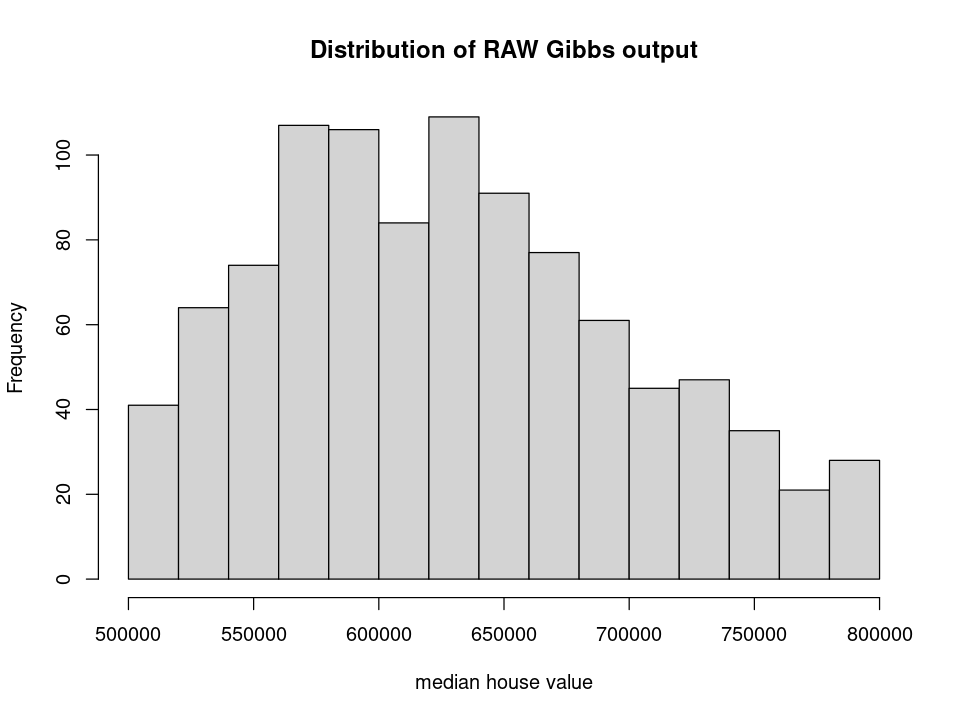

In [206]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(z_preds + 1, breaks=20, main="Distribution of RAW Gibbs output",
     xlab="median house value")


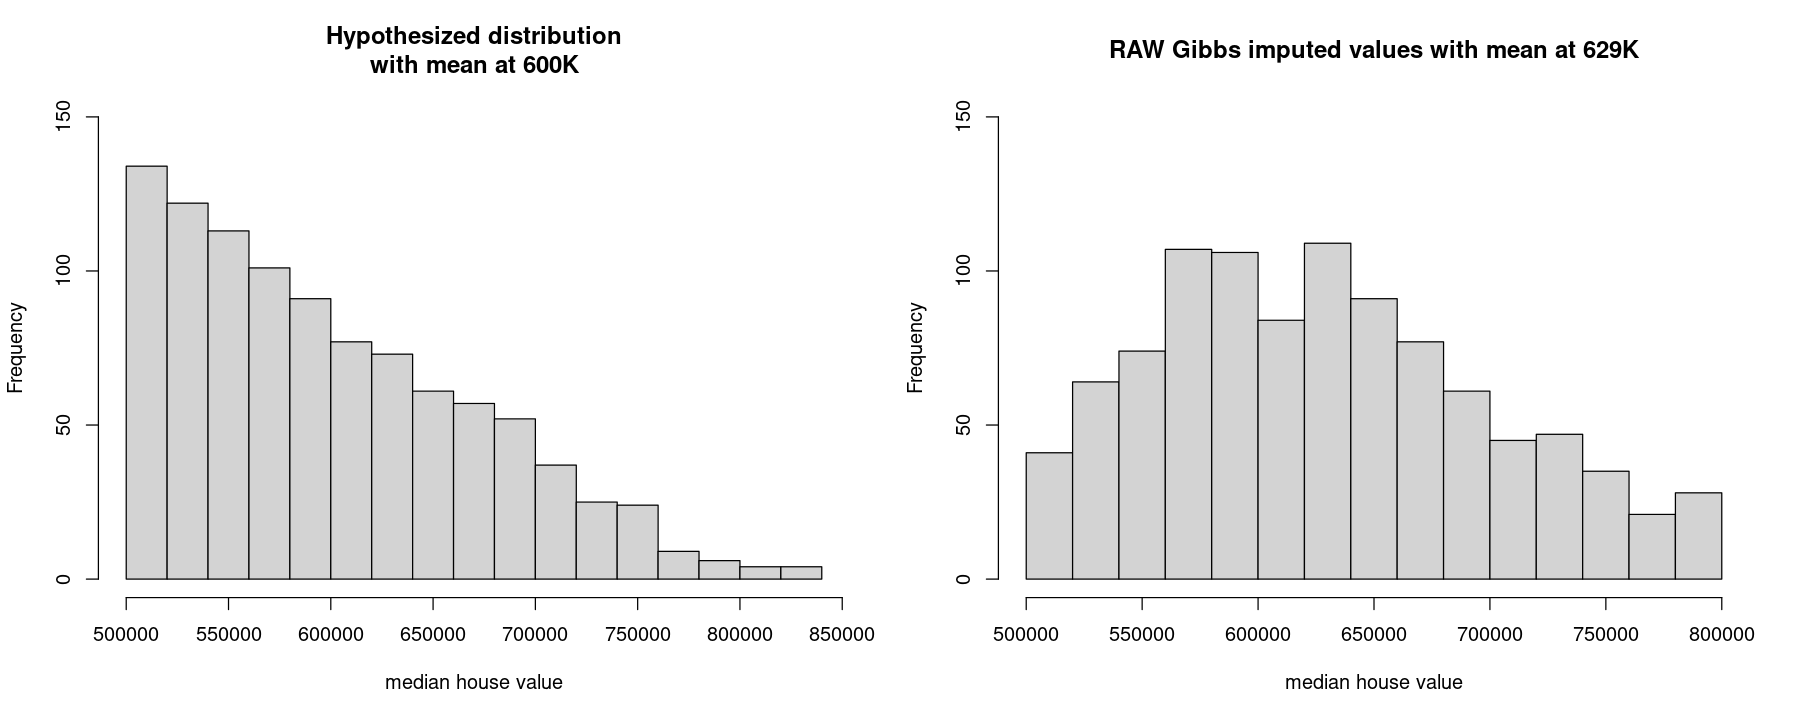

In [211]:
# Compare hypothesized distribution to the above distribution.

options(repr.plot.width= 15, repr.plot.height= 6)

mat <- t(as.matrix(c(1,2)))
layout(mat, widths = rep.int(20, ncol(mat)),
       heights = rep.int(7, nrow(mat)), respect = FALSE)

# Left panel.
hist(imputed_vals_tmp, breaks=20, main="Hypothesized distribution
with mean at 600K", ylim=c(0, 150), xlab="median house value")

# Right panel.
hist(z_preds, breaks=20, main="RAW Gibbs imputed values with mean at 629K",
     ylim=c(0, 150), xlab="median house value")


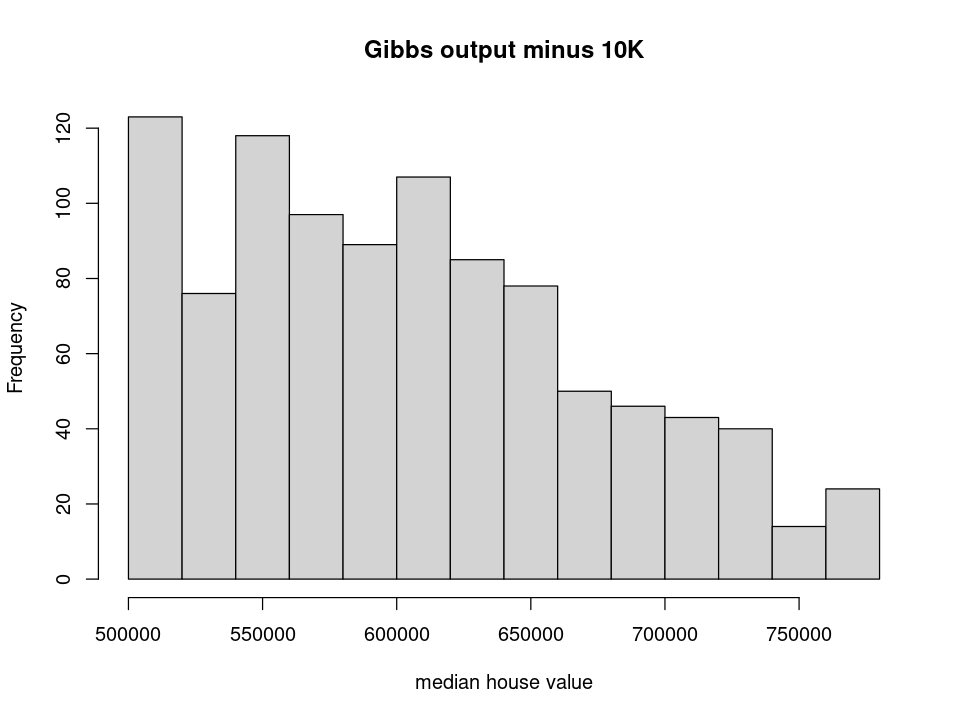

In [216]:
# Adjust the Gibbs output so that the mean is closer to
# 605K.

z_preds_adj <- z_preds - 25000
preds_adj <- ifelse(z_preds_adj < 500000, 500000, z_preds_adj)

options(repr.plot.width= 8, repr.plot.height= 6)

hist(preds_adj, breaks=14, main="Gibbs output minus 10K",
     xlab="median house value")


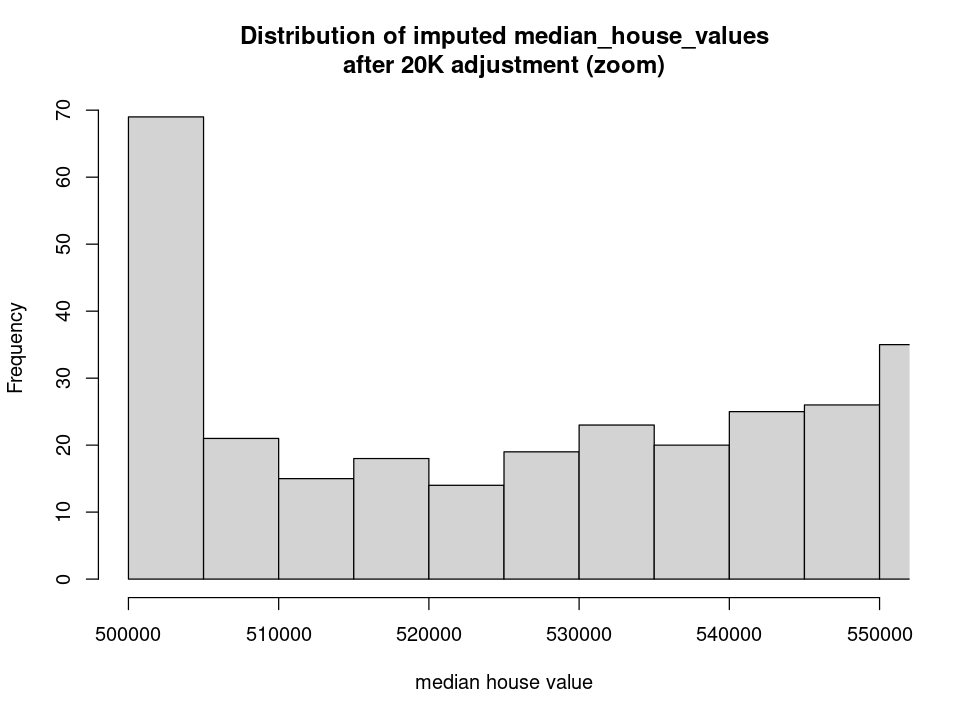

In [217]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(preds_adj + 100, breaks=40, 
     main="Distribution of imputed median_house_values
after 20K adjustment (zoom)", xlim= c(500000, 550000),
     xlab="median house value")


In [218]:
summary(preds_adj)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 500000  548851  599113  604761  652362  774914 

In [ ]:
### COMMENTS:

# The mean is now about where we have predicted it to be.

# But we do not expect there to be a sudden drop in the 
# number of districts from 500K to 505K; we expect the
# drop, if there is one, to be more gradual.

# We can fix this by adjusting z_means prior to 
# calling rnorm.trunc03.


In [221]:
# Instead of using 605K in what follows, we will need to over-
# correct a bit.

(z_means_bar <- mean(z_means))

z_means_adj <- z_means + (590000^response_var_power - z_means_bar)
summary(z_means_adj)
round(mean(z_means_adj)^inv_pwr)


[1] 11.031

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   10.9    10.9    10.9    10.9    11.0    11.3 

[1] 590000

In [225]:
C_upper


[1] 11.549

In [229]:
# Get some new, adjusted predictions.

# Also adjust C_upper a bit.

C_upper_adj <- 11.46

set.seed(1931)
preds_adj02 <- round(rnorm.trunc03(n.censored, z_means_adj, z_sds, lo=C, hi=C_upper_adj), 5)
preds_adj02 <- round(preds_adj02^inv_pwr)
summary(preds_adj02)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 500431  554334  598596  605688  648739  766141 

In [ ]:
### COMMENT:

# The mean is now around where we expect it to be.


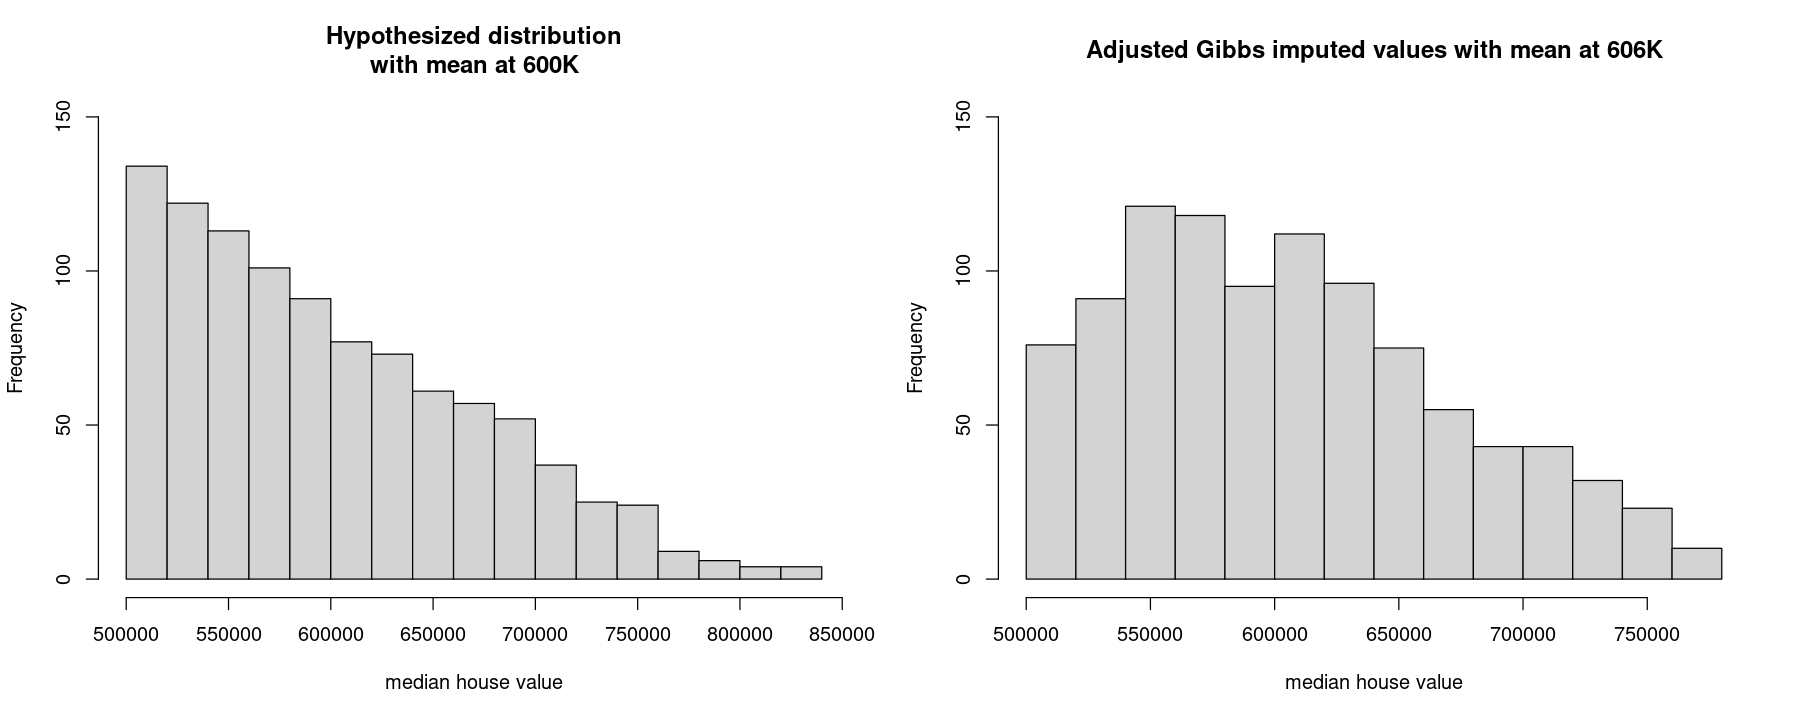

In [231]:
# Compare the adjusted values to the hypothesized distribution.

options(repr.plot.width= 15, repr.plot.height= 6)

mat <- t(as.matrix(c(1,2)))
layout(mat, widths = rep.int(20, ncol(mat)),
       heights = rep.int(7, nrow(mat)), respect = FALSE)

# Left panel.
hist(imputed_vals_tmp, breaks=20, main="Hypothesized distribution
with mean at 600K", ylim=c(0, 150), xlab="median house value")

# Right panel.
hist(preds_adj02, breaks=14, main="Adjusted Gibbs imputed values with mean at 606K",
     ylim=c(0, 150), xlab="median house value")


In [ ]:
### COMMENT:

# The shape of the adjusted Gibbs output is still fairly
# different from what we hypothesize; one would expect 
# more values to be found between 500K and 550K.  This 
# is not something we can do much about without disturbing
# the random nature of the Gibbs output.  My experience is
# that if we try to manually change the shape of the 
# distribution (this can be done without changing the order
# of the predictions), we adversely affect the RSS gain
# (see Appendix C for the RSS gain measure).


In [232]:
# Assign imputed values.

newdat <- dat
newdat$median_house_value[censored] <- preds_adj02
summary(newdat$median_house_value)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  15000  119600  179800  211987  264950  766141 

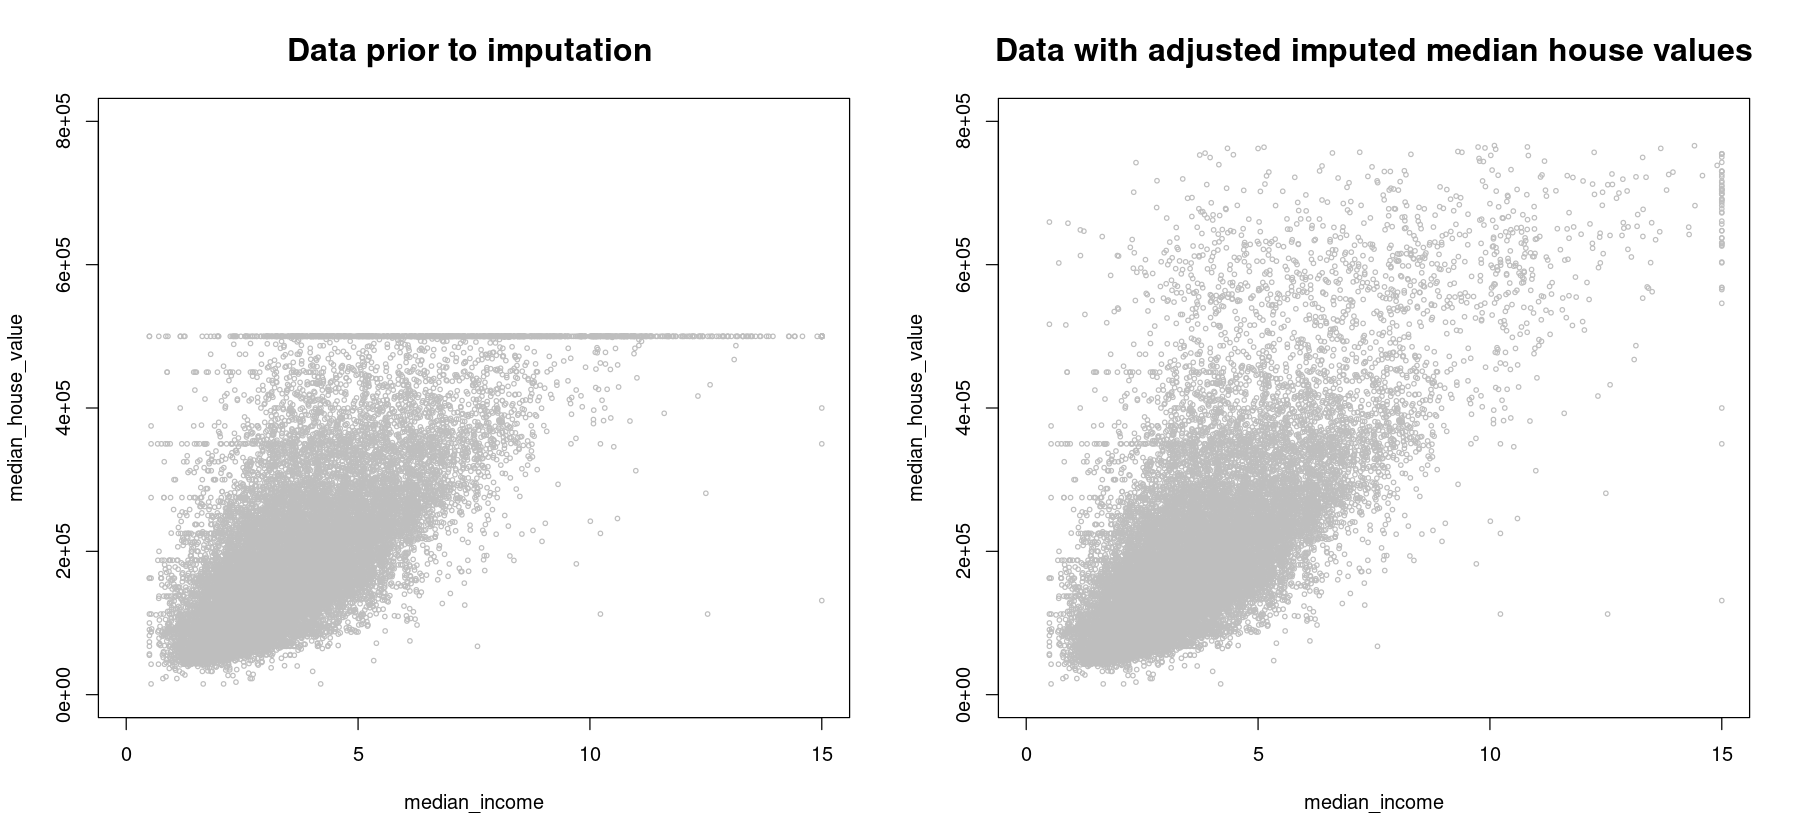

In [233]:
# Plot both before and after.

options(repr.plot.width= 15, repr.plot.height= 7)

mat <- t(as.matrix(c(1,2)))
layout(mat, widths = rep.int(20, ncol(mat)),
       heights = rep.int(7, nrow(mat)), respect = FALSE)

# layout.show(n = 2)

# plot the "before" scatter
plot(dat$median_income, dat$median_house_value, type= "p", pch=1, cex=0.5, col="grey",
     xlab= "median_income", ylab= "median_house_value", ylim= c(0, 0.80e06), xlim= c(0, 15),
     main= "Data prior to imputation ", cex.main=1.6)


# plot the newly predicted values
plot(newdat$median_income, newdat$median_house_value, type= "p", pch=1, cex=0.5, col="grey",
     xlab= "median_income", ylab= "median_house_value", ylim= c(0, 0.80e06), xlim= c(0, 15),
     main= "Data with adjusted imputed median house values", cex.main=1.6)


### Save to disk

In [234]:
# Save imputed values for median_house_value.

write.csv(newdat,
          file="/home/greg/Documents/stat/Geron_ML/datasets/housing/housing_cleaned_v03pt5.csv",
          row.names=TRUE)


In [235]:
dat <- newdat
rm(newdat)


## Final Comments for Appendix B

A check to see that the imputed values are consistent with the data and with the Gibbs sampler output is made in Section 2 of Part01.  Material in Appendix C also helps to make the case that this method of adjusting the Gibbs output "works" and in fact is an improvement upon the raw Gibbs output.

The Gibbs sampler method of imputation does not necessarily give us an appropriate distribution shape for the imputed values, nor even an appropriate mean.  In appendices A and B I have shown how we can predict with some confidence where the mean of the imputed values ought to lie.  As we will see in Appendix C, adjusting the Gibbs output to re-situate the mean can be done without adversely affecting the quality of the predictions (in terms of the RSS gain measure discussed in Appendix C).

When imputing values at the tail of a variable's distribution, the Gibbs sampler does not know that we are near the tail.  This is one reason why the output from the Gibbs sampler is likely to have a mean that is too high, and it is a reason why the distribution of the imputed values is likely to not be consistent with what we expect.  To correct for a mean that is too high, we can shift the Gibbs output to the left.  This increases the record counts near the cap for the censored data.  This is good because it causes the distribution of the Gibbs output to look more like what we expect at the tail.  Beyond this, we cannot do much about the shape of the output without adversely affecting the quality of the predictions.  An example of this is shown in Appendix C.  

